<a href="https://colab.research.google.com/github/httpsdave/thematic/blob/main/Trend_Analysis_of_Research_Focus_in_Undergraduate_Thesis_and_Capstone_Projects_in_the_College_of_Computer_Studies_at_One_State_University.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.0 --force-reinstall


COMPREHENSIVE THEMATIC ANALYSIS OF RESEARCH TRENDS
==================================================
A systematic analysis of research themes, trends, and patterns in thesis and capstone abstracts (2005-2023)

Imports and Setup

In [ ]:
# Libraries for data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries and tools
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text to numeric importance values
from sklearn.decomposition import NMF  # Used for topic modeling
from nltk.corpus import stopwords
nltk.download('stopwords')  # Download stopwords to filter common, unimportant words

# Additional NLP tools from NLTK
from nltk.tokenize import word_tokenize, sent_tokenize  # Break text into words or sentences
from nltk.tag import pos_tag  # Label words with part-of-speech (noun, verb, etc.)
from nltk.chunk import ne_chunk  # Identify names, places, organizations
from nltk.util import ngrams  # Create sequences of words (e.g., 2-word phrases)
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline
from nltk.lm import MLE, Laplace  # Language models for predicting words
from nltk.wsd import lesk  # Word sense disambiguation (choose correct meaning)
from nltk.corpus import wordnet as wn  # Word meanings and relationships

# Tools for similarity and dimensionality reduction (for visualizing data)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Load spaCy for advanced NLP tasks
import spacy

# Download necessary NLTK models and datasets
nltk_downloads = [
    'stopwords', 'punkt', 'punkt_tab', 'averaged_perceptron_tagger',
    'maxent_ne_chunker', 'words', 'wordnet', 'omw-1.4',
    'averaged_perceptron_tagger_eng'
]
for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)  # Download without output
    except:
        pass  # Skip if already downloaded

# Try to load spaCy English model (used for tokenization, tagging, etc.)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")
    nlp = None  # Prevent errors if spaCy isn't installed


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load and Inspect Dataset

In [ ]:
# Load the dataset containing thesis/capstone project data
df = pd.read_csv('trend_analysis dataset.csv')
print(f"Dataset loaded: {len(df)} records")  # Print how many records were loaded


Dataset loaded: 504 records


In [ ]:
# DUPLICATE REMOVAL - Add this section after loading your data
def remove_exact_duplicates(df, text_column=None):
    """
    Remove exact duplicate records from the dataset

    Parameters:
    df: pandas DataFrame
    text_column: str, name of the column containing text data (optional)
               If None, removes duplicates based on all columns

    Returns:
    pandas DataFrame with exact duplicates removed
    """
    initial_count = len(df)

    if text_column:
        # Remove exact duplicates based on specific text column
        df_clean = df.drop_duplicates(subset=[text_column], keep='first')
    else:
        # Remove duplicates considering all columns
        df_clean = df.drop_duplicates(keep='first')

    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} exact duplicate records ({removed_count/initial_count*100:.1f}%)")
    print(f"Remaining records: {len(df_clean)}")

    return df_clean

# Simple one-liner alternatives:
# For text column duplicates: df_clean = df.drop_duplicates(subset=['text_column'], keep='first')
# For all column duplicates: df_clean = df.drop_duplicates(keep='first')

# Additional duplicate checking options:
def check_duplicates(df, text_column):
    """Check for different types of duplicates in the dataset"""
    print("=== DUPLICATE ANALYSIS ===")

    # Check exact duplicates in text column
    exact_dups = df[text_column].duplicated().sum()
    print(f"Exact text duplicates: {exact_dups}")

    # Check duplicates across all columns
    all_dups = df.duplicated().sum()
    print(f"Exact row duplicates: {all_dups}")

    # Check for empty/null values
    null_values = df[text_column].isnull().sum()
    print(f"Null/empty text values: {null_values}")

    # Show some duplicate examples if they exist
    if exact_dups > 0:
        print("\nExample duplicate texts:")
        duplicate_texts = df[df[text_column].duplicated(keep=False)][text_column].head(5)
        for i, text in enumerate(duplicate_texts, 1):
            print(f"{i}. {text[:100]}...")

    return exact_dups, all_dups, null_values

Data Cleaning and Preprocessing Pipeline

In [ ]:
import re

def clean_text(text):
    """Clean and normalize text data"""
    if pd.isna(text):
        return ""
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters and punctuation
    return text

def preprocess_data(df):
    """Prepare dataset for NLP analysis"""
    print("Starting data preprocessing...")

    # Remove records with missing Titles or Abstract Keywords
    initial_len = len(df)
    df = df.dropna(subset=['Title', 'Abstract Keywords']).copy()
    print(f"Removed {initial_len - len(df)} rows with missing data")

    # Clean abstract keywords for analysis
    df['cleaned_keywords'] = df['Abstract Keywords'].apply(clean_text)

    # Ensure 'Year' is in numeric format
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

    # Label projects as Capstone (for BSIT) or Thesis (for other programs)
    df['ProjectType'] = df['Program'].apply(lambda x: 'Capstone' if 'BSIT' in str(x) else 'Thesis')

    print(f"Preprocessing completed. Final dataset: {len(df)} records")
    return df

def apply_nlp_analysis(df):
    """Extract topics and identify research methods using NLP"""
    print("Applying NLP analysis...")

    # 1. Convert cleaned keywords into numeric features using TF-IDF
    vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_keywords'])

    # 2. Apply NMF topic modeling to identify common research themes
    nmf_model = NMF(n_components=5, random_state=42)
    W = nmf_model.fit_transform(X)

    # Map each topic number to a manually defined theme name
    topic_names = {
        0: "System Testing and Evaluation",
        1: "Game Development and Design",
        2: "E-Commerce and Online Information Systems",
        3: "Educational Tools and Learning Systems",
        4: "Mobile Application Development and Usability"
    }

    # Assign most likely topic to each record
    df['topic'] = W.argmax(axis=1)
    df['theme'] = df['topic'].map(topic_names)

    # 3. Add flags for presence of specific research methodologies
    methodology_keywords = ['quantitative', 'qualitative', 'mixed methods', 'experiment',
                            'survey', 'case study', 'prototype', 'development', 'algorithm',
                            'implementation', 'evaluation', 'testing']

    for keyword in methodology_keywords:
        # Create a binary column indicating whether the keyword appears in the cleaned text
        df[f'has_{keyword}'] = df['cleaned_keywords'].str.contains(keyword, case=False).astype(int)

    print("NLP analysis completed.")
    return df

# Run preprocessing and NLP analysis on the loaded dataset
df = preprocess_data(df)
df = apply_nlp_analysis(df)


Starting data preprocessing...
Removed 3 rows with missing data
Preprocessing completed. Final dataset: 501 records
Applying NLP analysis...
NLP analysis completed.


Frequency Analysis of Keywords (Objective 1)

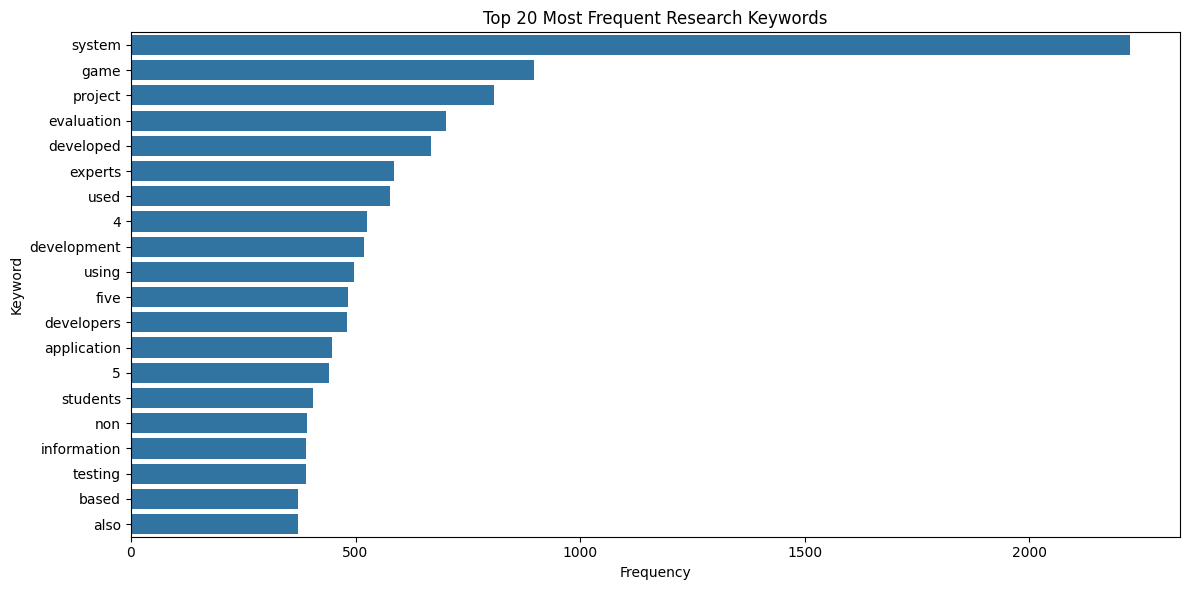

In [ ]:
# Combine all keywords
all_words = ' '.join(df['cleaned_keywords'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words.split() if word not in stop_words]

# Create frequency distribution
from collections import Counter
word_freq = Counter(filtered_words)

# Convert to DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Keyword', 'Frequency'])

# Plot top 20 keywords
plt.figure(figsize=(12,6))
sns.barplot(x='Frequency', y='Keyword', data=freq_df)
plt.title('Top 20 Most Frequent Research Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.tight_layout()
plt.show()

Word Cloud of Themes (Visual Support)

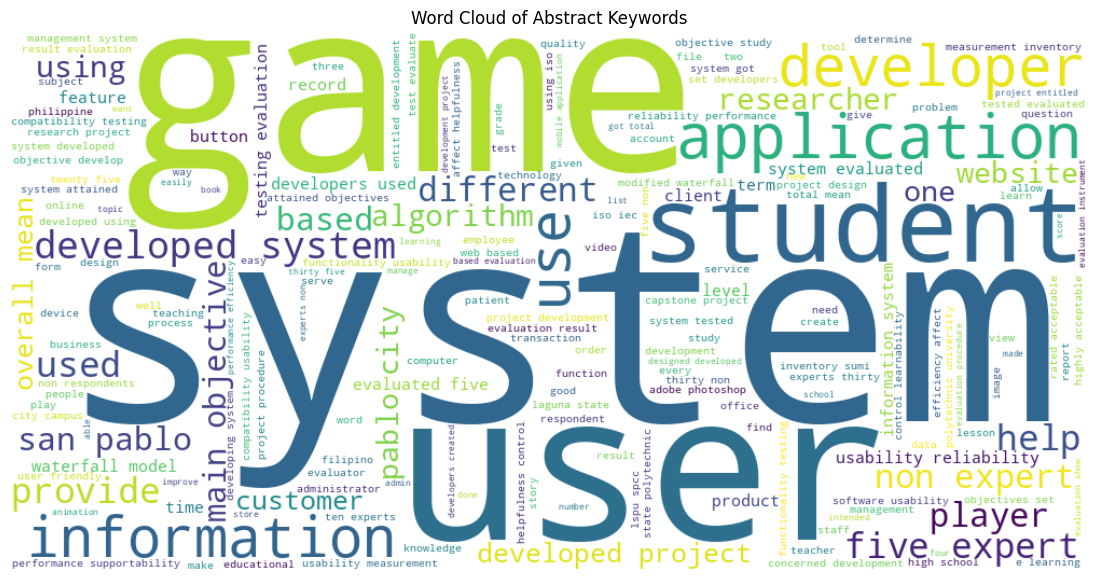

In [ ]:
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstract Keywords')
plt.show()


POS Tagging and Technical Term Extraction

<ipython-input-8-735ff58e289d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x='Frequency', y='POS_Tag', palette='viridis')


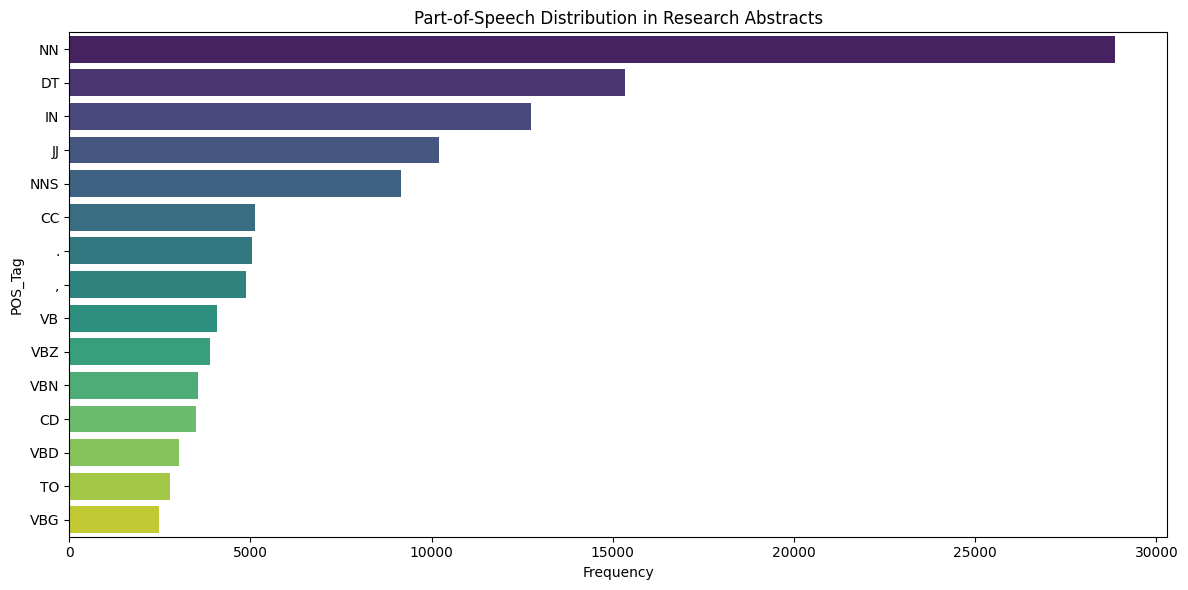

Top Technical Terms (Nouns & Adjectives):
Technical_Term  Frequency
        system       2222
          game        889
       project        804
    evaluation        698
       experts        580
   development        517
    developers        481
   application        445
      students        401
   information        389
     developed        382
         users        340
     usability        326
     different        323
    acceptable        321
 functionality        305
          mean        298
         study        287
   respondents        277
          user        275


In [ ]:

# POS Tagging and Technical Term Extraction

def perform_pos_analysis(df):
    """Perform POS tagging and syntactic analysis on abstracts"""

    # Combine all abstracts for POS analysis
    all_abstracts = ' '.join(df['Abstract Keywords'].fillna(''))

    # Tokenize and POS tag
    tokens = word_tokenize(all_abstracts.lower())
    pos_tags = pos_tag(tokens)

    # Count POS categories
    pos_counts = Counter([tag for word, tag in pos_tags])

    # Create POS distribution dataframe
    pos_df = pd.DataFrame(list(pos_counts.items()), columns=['POS_Tag', 'Frequency'])
    pos_df = pos_df.sort_values('Frequency', ascending=False).head(15)

    # Visualize POS distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(data=pos_df, x='Frequency', y='POS_Tag', palette='viridis')
    plt.title('Part-of-Speech Distribution in Research Abstracts')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Extract technical terms (nouns and adjectives)
    technical_terms = []
    for word, tag in pos_tags:
        if tag in ['NN', 'NNS', 'JJ', 'JJR', 'JJS'] and len(word) > 3:
            technical_terms.append(word)

    # Most common technical terms
    tech_term_freq = Counter(technical_terms).most_common(20)
    tech_df = pd.DataFrame(tech_term_freq, columns=['Technical_Term', 'Frequency'])

    print("Top Technical Terms (Nouns & Adjectives):")
    print(tech_df.to_string(index=False))

    return pos_df, tech_df

# Apply POS analysis
pos_distribution, technical_terms = perform_pos_analysis(df)

Thematic Clustering using NMF (Objective 1)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


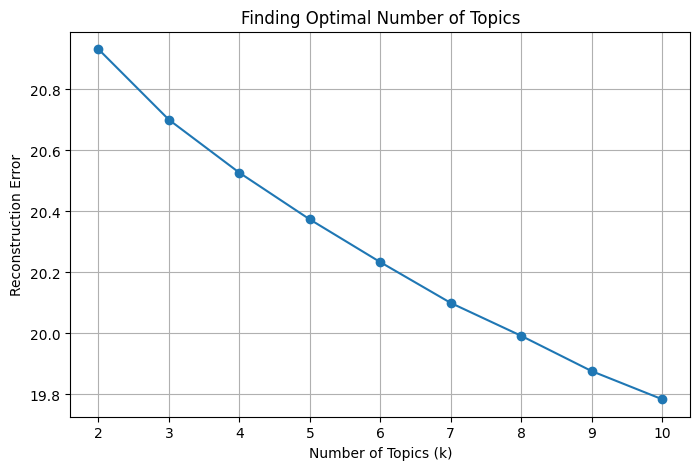


Topic #1:
project, testing, developers, developed, 25010, compatibility, experts, respondents, iso, evaluate

Topic #2:
game, player, acceptable, games, players, android, algorithm, adventure, play, different

Topic #3:
information, website, online, san, customers, city, pablo, users, products, laguna

Topic #4:
learning, students, school, button, grade, teachers, animation, subject, student, computer

Topic #5:
application, android, mobile, algorithm, user, evaluation, using, functionality, users, usability


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_keywords'])

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

errors = []

# Try N topics from 2 to 10
for k in range(2, 11):
    nmf_model = NMF(n_components=k, random_state=42)
    W = nmf_model.fit_transform(X)
    error = nmf_model.reconstruction_err_
    errors.append(error)

# Plot the reconstruction error for each value of k
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), errors, marker='o')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Reconstruction Error')
plt.title('Finding Optimal Number of Topics')
plt.grid(True)
plt.show()


# Topic Modeling with NMF
nmf_model = NMF(n_components=5, random_state=42)  # adjust n_components for more/fewer themes
W = nmf_model.fit_transform(X)
H = nmf_model.components_

# Extract top words per topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    print(f"\nTopic #{topic_idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


N-gram Modeling and Language Model Creation

<ipython-input-10-7a1482a63a4f>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df.head(10), x='Frequency', y='Bigram_Text', palette='Set2')
<ipython-input-10-7a1482a63a4f>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_df.head(10), x='Frequency', y='Trigram_Text', palette='Set3')


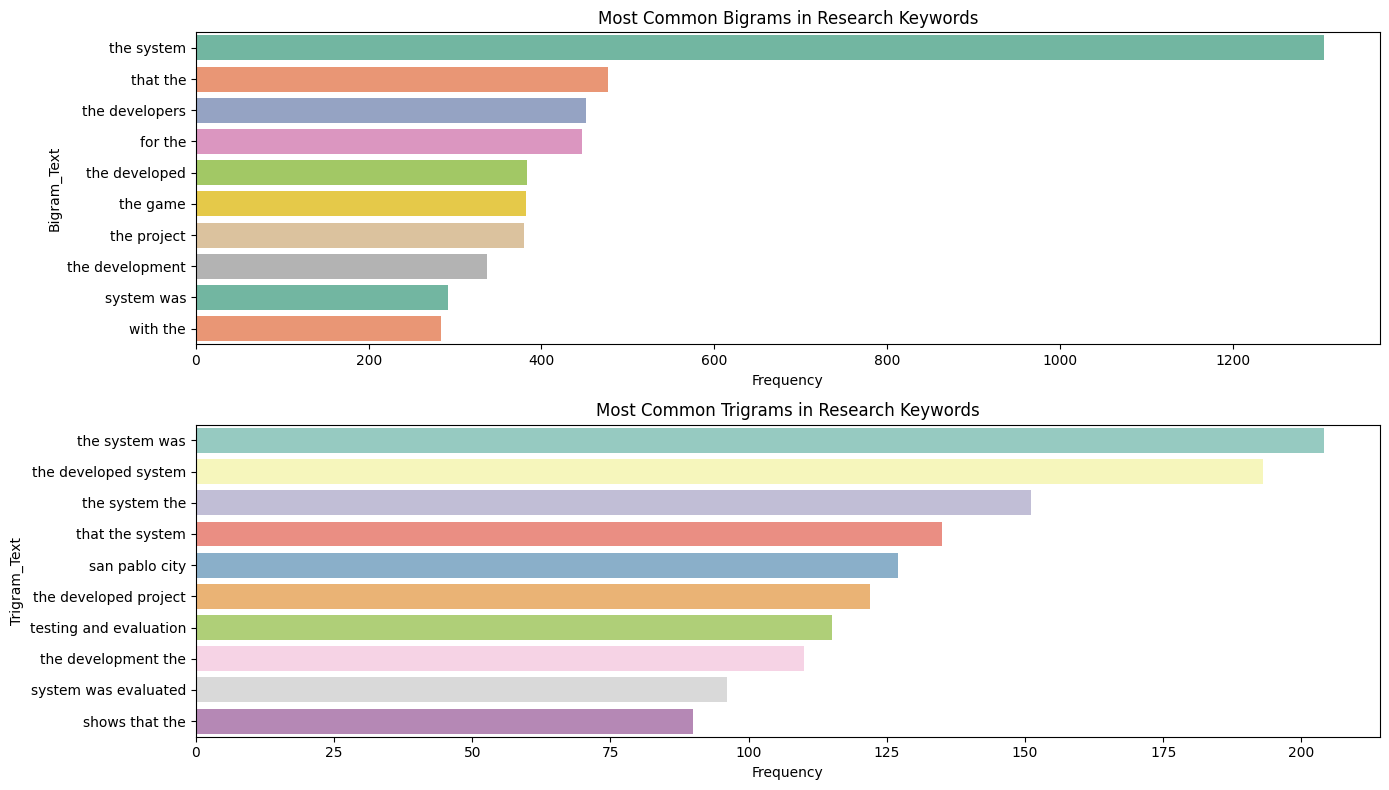

N-gram Analysis Results:
Total unique bigrams: 36732
Total unique trigrams: 59760

Top Bigrams:
  the system: 1305
  that the: 477
  the developers: 452
  for the: 447
  the developed: 383
  the game: 382
  the project: 380
  the development: 337
  system was: 292
  with the: 284


In [ ]:
def create_ngram_models(df, n=3):
    """Create n-gram models with back-off for research abstracts"""

    # Prepare text data
    all_text = ' '.join(df['cleaned_keywords'].fillna(''))
    tokens = word_tokenize(all_text.lower())

    # Remove very short words and numbers
    tokens = [token for token in tokens if len(token) > 2 and token.isalpha()]

    # Create bigrams and trigrams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))

    # Count n-grams
    bigram_freq = Counter(bigrams)
    trigram_freq = Counter(trigrams)

    # Most common bigrams and trigrams
    common_bigrams = bigram_freq.most_common(20)
    common_trigrams = trigram_freq.most_common(15)

    # Create DataFrames for visualization
    bigram_df = pd.DataFrame(common_bigrams, columns=['Bigram', 'Frequency'])
    bigram_df['Bigram_Text'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))

    trigram_df = pd.DataFrame(common_trigrams, columns=['Trigram', 'Frequency'])
    trigram_df['Trigram_Text'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))

    # Visualize bigrams and trigrams
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    sns.barplot(data=bigram_df.head(10), x='Frequency', y='Bigram_Text', palette='Set2')
    plt.title('Most Common Bigrams in Research Keywords')
    plt.xlabel('Frequency')

    plt.subplot(2, 1, 2)
    sns.barplot(data=trigram_df.head(10), x='Frequency', y='Trigram_Text', palette='Set3')
    plt.title('Most Common Trigrams in Research Keywords')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

    print("N-gram Analysis Results:")
    print(f"Total unique bigrams: {len(bigram_freq)}")
    print(f"Total unique trigrams: {len(trigram_freq)}")
    print("\nTop Bigrams:")
    for bigram, freq in common_bigrams[:10]:
        print(f"  {' '.join(bigram)}: {freq}")

    return bigram_df, trigram_df

# Apply n-gram analysis
bigram_results, trigram_results = create_ngram_models(df)

Theme Distribution by Year

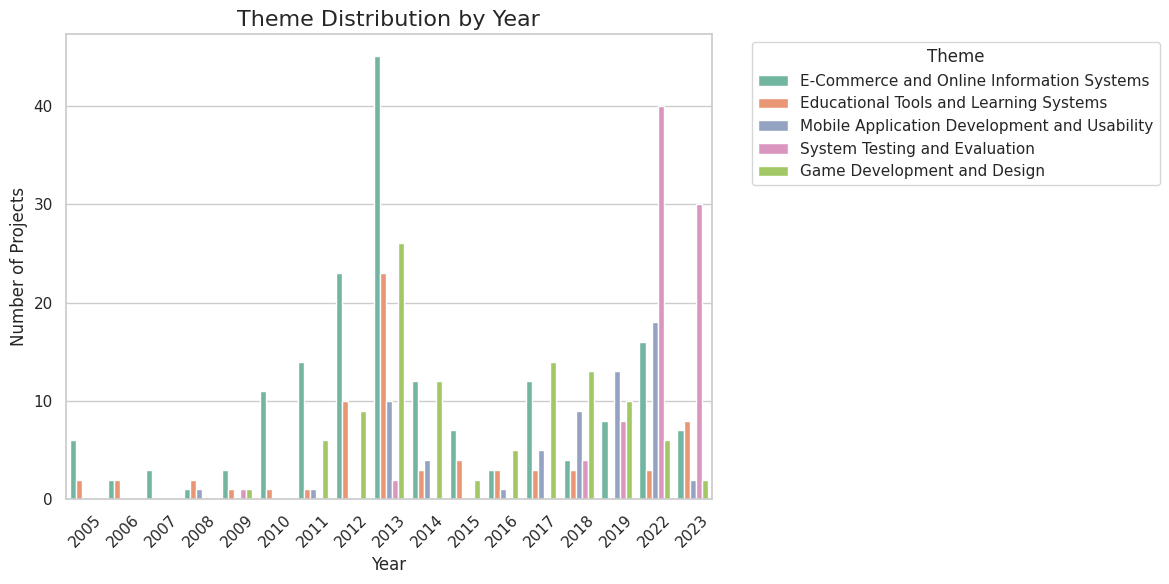

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Countplot grouped by year and theme
sns.countplot(data=df, x='Year', hue='theme', palette='Set2')

# Labels and formatting
plt.title('Theme Distribution by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Semantic Analysis and Document Similarity

Most Similar Documents:
                                           Doc1_Title                                            Doc2_Title  Similarity
                  BACK TO BEGINNING (3D ANIMATION)... THE DEVELOPMENT OF "BACK TO BEGINNING (3D ANIMATIO...         1.0
THE DEVELOPMENT OF A SIDE SCROLLING GAME: "CHIBITO...                    CHIBITOPIA: CHALICE OF CGASTITY...         1.0
DATA MANAGEMENT AND CONSULTATION UPDATE USING SHOR... DATA MANAGEMENT AND COSULTATION UPDATE USING SHORT...         1.0
DEVELOPMENT OF PHILIPPINE AGE LOST IN THE PAST : T... DEVELOPMENT OF PHILIPPINE AGE: LOST IN THE PAST "T...         1.0
THE DEVELOPMENT OF CREATIVE MODA DE PRIMERA OFFICI... THE DEVELOPMENT OF CREATIVE MODA DE PRIMERA OFFICI...         1.0


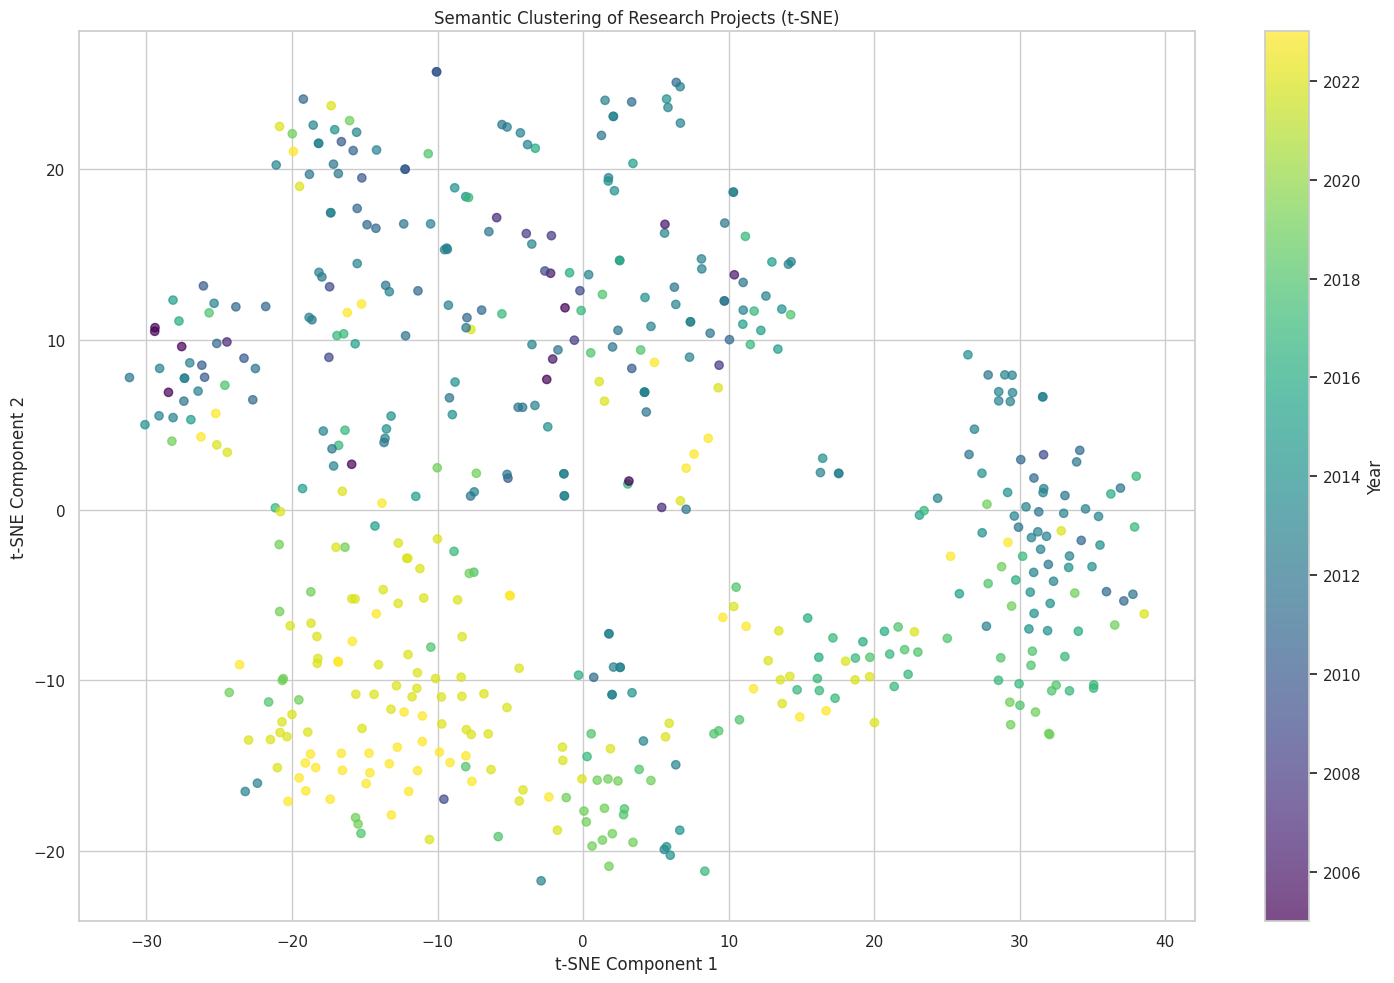

In [ ]:
def semantic_analysis(df):
    """Perform semantic analysis using TF-IDF and cosine similarity"""

    # Create TF-IDF vectors for each document
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1,2))
    tfidf_matrix = vectorizer.fit_transform(df['cleaned_keywords'].fillna(''))

    # Calculate document similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Find most similar documents
    similarity_pairs = []
    n_docs = len(df)

    for i in range(n_docs):
        for j in range(i+1, n_docs):
            if similarity_matrix[i][j] > 0.3:  # Threshold for similarity
                similarity_pairs.append({
                    'Doc1_Index': i,
                    'Doc2_Index': j,
                    'Doc1_Title': df.iloc[i]['Title'][:50] + '...',
                    'Doc2_Title': df.iloc[j]['Title'][:50] + '...',
                    'Similarity': similarity_matrix[i][j],
                    'Year1': df.iloc[i]['Year'],
                    'Year2': df.iloc[j]['Year']
                })

    # Convert to DataFrame and sort by similarity
    similarity_df = pd.DataFrame(similarity_pairs)
    if not similarity_df.empty:
        similarity_df = similarity_df.sort_values('Similarity', ascending=False).head(20)
        print("Most Similar Documents:")
        print(similarity_df[['Doc1_Title', 'Doc2_Title', 'Similarity']].head().to_string(index=False))

    # Semantic clustering using t-SNE (only if enough documents)
    if tfidf_matrix.shape[0] > 10:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df)//2))
        embeddings_2d = tsne.fit_transform(tfidf_matrix.toarray())

        # Plot semantic clusters
        plt.figure(figsize=(15, 10))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=df['Year'], cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Year')
        plt.title('Semantic Clustering of Research Projects (t-SNE)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.tight_layout()
        plt.show()

        return similarity_df, embeddings_2d

    return similarity_df, None

# Apply semantic analysis
doc_similarities, semantic_embeddings = semantic_analysis(df)

Frequency Table by Program and Year

In [ ]:
# Create frequency table
theme_freq_table = df.pivot_table(index=['Program', 'Year'],
                                   columns='theme',
                                   aggfunc='size',
                                   fill_value=0)

# Display the first few rows
theme_freq_table


theme         E-Commerce and Online Information Systems  \
Program Year                                              
BSCS    2016                                          0   
        2017                                          3   
        2018                                          0   
        2019                                          1   
        2022                                          2   
        2023                                          5   
BSIT    2005                                          6   
        2006                                          2   
        2007                                          3   
        2008                                          1   
        2009                                          3   
        2010                                         11   
        2011                                         14   
        2012                                         23   
        2013                                         42   
        2014                                         12   
        2015                                          7   
        2016                                          3   
        2017                                          9   
        2018                                          4   
        2019                                          7   
        2022                                         13   
        2023                                          2   
BSSA    2013                                          3   
MSIT    2022                                          1   

theme         Educational Tools and Learning Systems  \
Program Year                                           
BSCS    2016                                       3   
        2017                                       1   
        2018                                       0   
        2019                                       0   
        2022                                       1   
        2023                                       6   
BSIT    2005                                       2   
        2006                                       2   
        2007                                       0   
        2008                                       2   
        2009                                       1   
        2010                                       1   
        2011                                       1   
        2012                                      10   
        2013                                      23   
        2014                                       3   
        2015                                       4   
        2016                                       0   
        2017                                       2   
        2018                                       3   
        2019                                       0   
        2022                                       2   
        2023                                       2   
BSSA    2013                                       0   
MSIT    2022                                       0   

theme         Game Development and Design  \
Program Year                                
BSCS    2016                            3   
        2017                            6   
        2018                            7   
        2019                            0   
        2022                            5   
        2023                            0   
BSIT    2005                            0   
        2006                            0   
        2007                            0   
        2008                            0   
        2009                            1   
        2010                            0   
        2011                            6   
        2012                            9   
        2013                           26   
        2014                           12   
        2015                            2   
        2016                          

Bar Chart Showing Theme Proportions

<ipython-input-14-67617291a0e5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.index, y=theme_counts.values, palette="Set3")


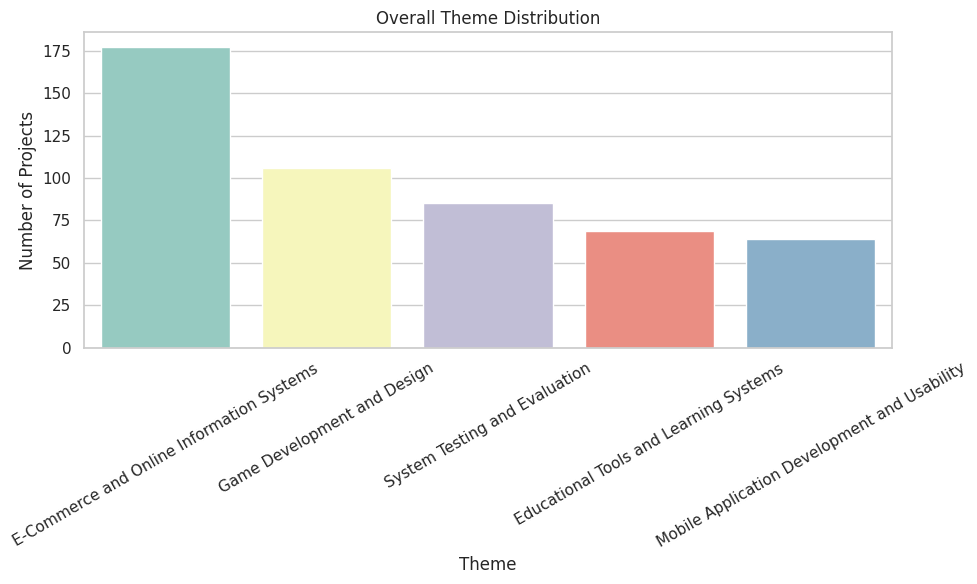

In [ ]:
theme_counts = df['theme'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=theme_counts.index, y=theme_counts.values, palette="Set3")
plt.title("Overall Theme Distribution")
plt.ylabel("Number of Projects")
plt.xlabel("Theme")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Trend Lines per Theme Across Years

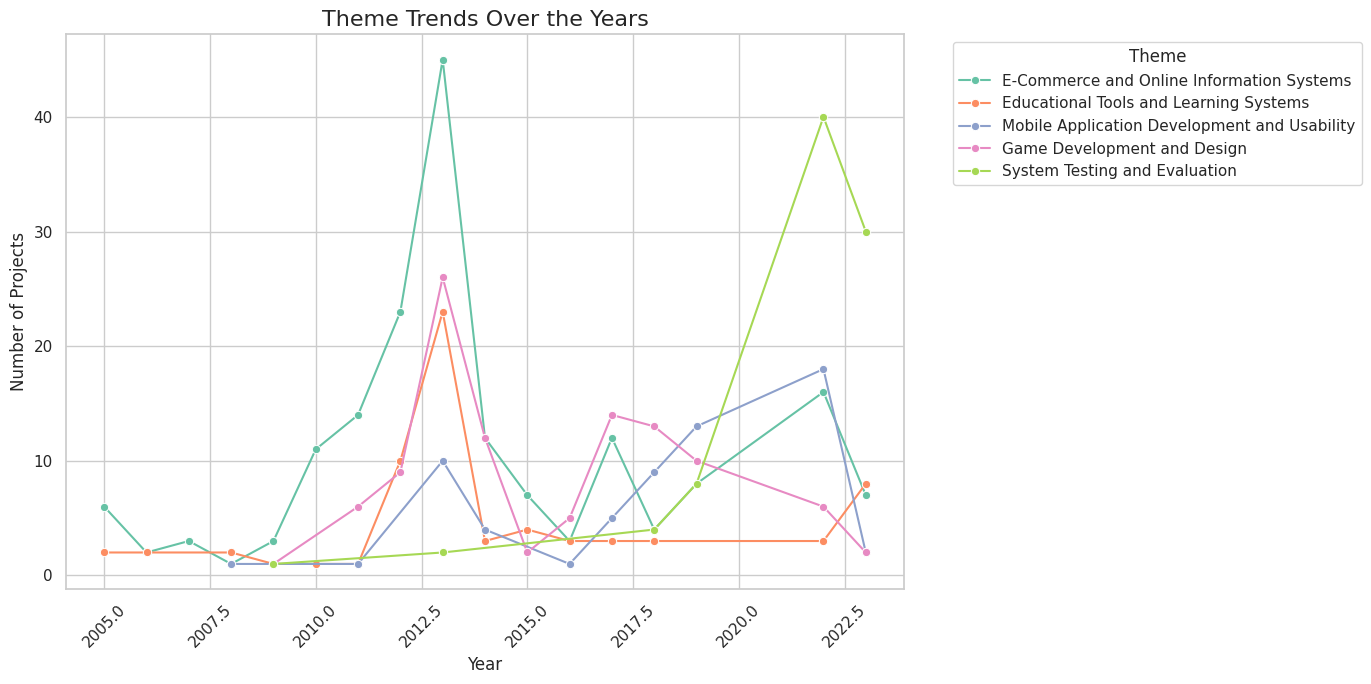

In [ ]:
# Count projects per theme per year
theme_trends = df.groupby(['Year', 'theme']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=theme_trends, x='Year', y='count', hue='theme', marker="o", palette="Set2")

plt.title("Theme Trends Over the Years", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Projects")
plt.xticks(rotation=45)
plt.legend(title="Theme", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


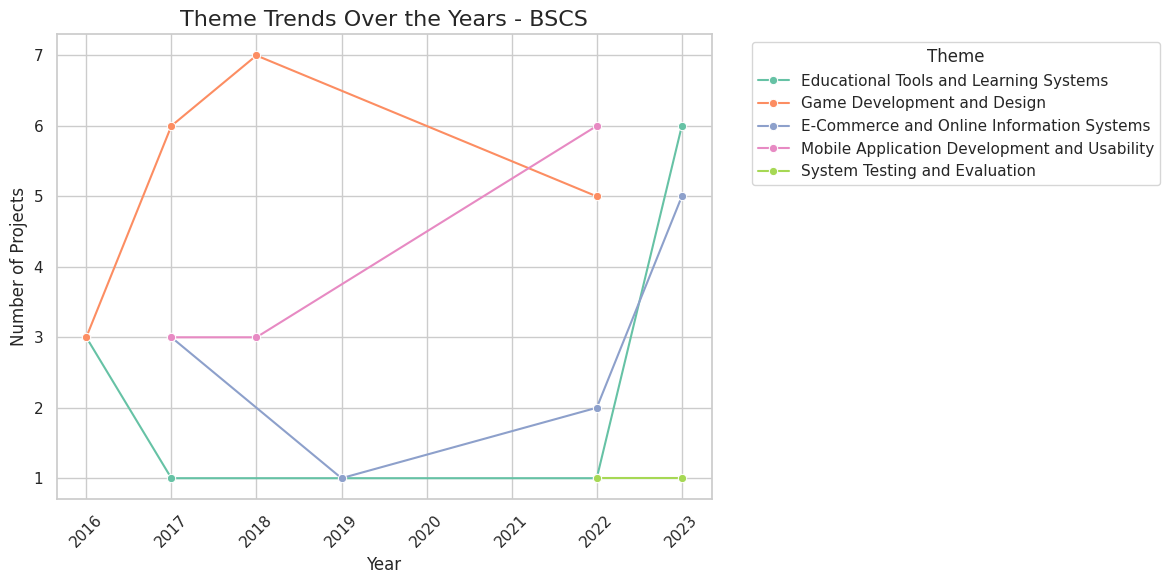

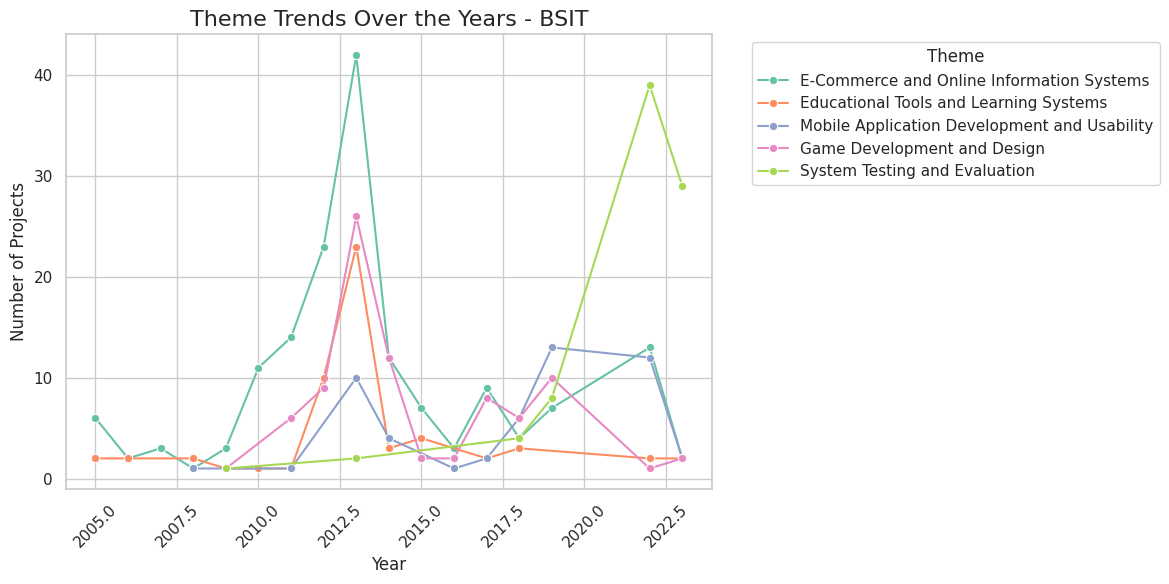

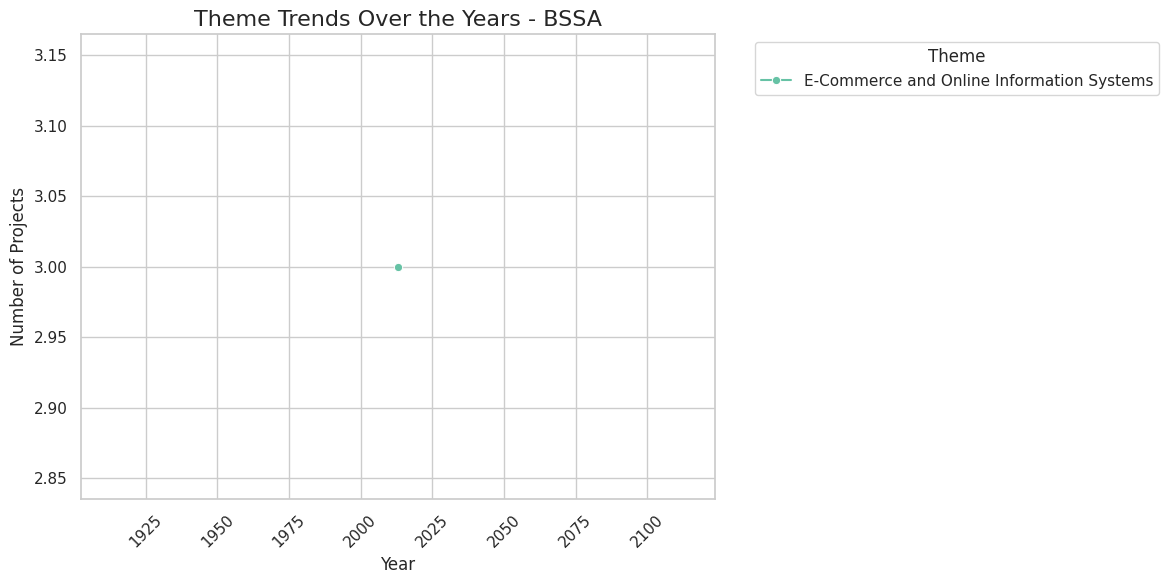

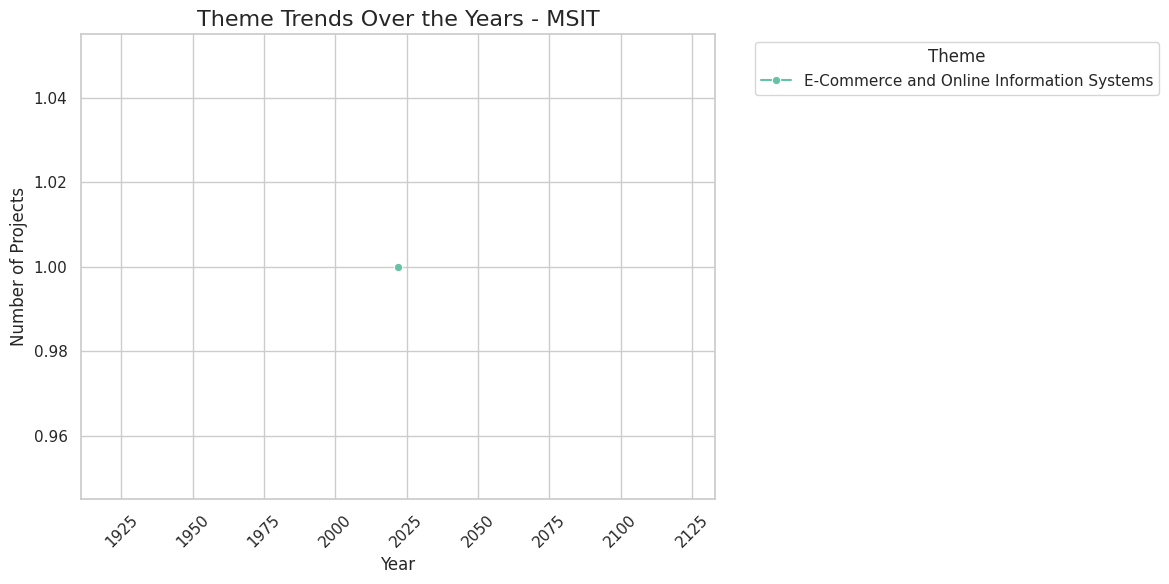

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data to prepare for trend analysis
theme_program_trends = df.groupby(['Program', 'Year', 'theme']).size().reset_index(name='count')

# Make sure data is sorted by year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # convert Year to numeric
theme_program_trends = theme_program_trends.sort_values(by=['Program', 'Year'])

# Plot each program's theme trend separately
sns.set(style="whitegrid")
programs = theme_program_trends['Program'].unique()

for program in programs:
    program_data = theme_program_trends[theme_program_trends['Program'] == program]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=program_data, x='Year', y='count', hue='theme', marker='o', palette='Set2')

    plt.title(f"Theme Trends Over the Years - {program}", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Number of Projects")
    plt.xticks(rotation=45)
    plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Cross-tab: Theme vs Program

In [ ]:
# Cross-tabulation: Themes by Program
theme_program_crosstab = pd.crosstab(df['theme'], df['Program'])

# Display the table
theme_program_crosstab

Program,BSCS,BSIT,BSSA,MSIT
theme,,,,
E-Commerce and Online Information Systems,11,162,3,1
Educational Tools and Learning Systems,11,58,0,0
Game Development and Design,21,85,0,0
Mobile Application Development and Usability,12,52,0,0
System Testing and Evaluation,2,83,0,0


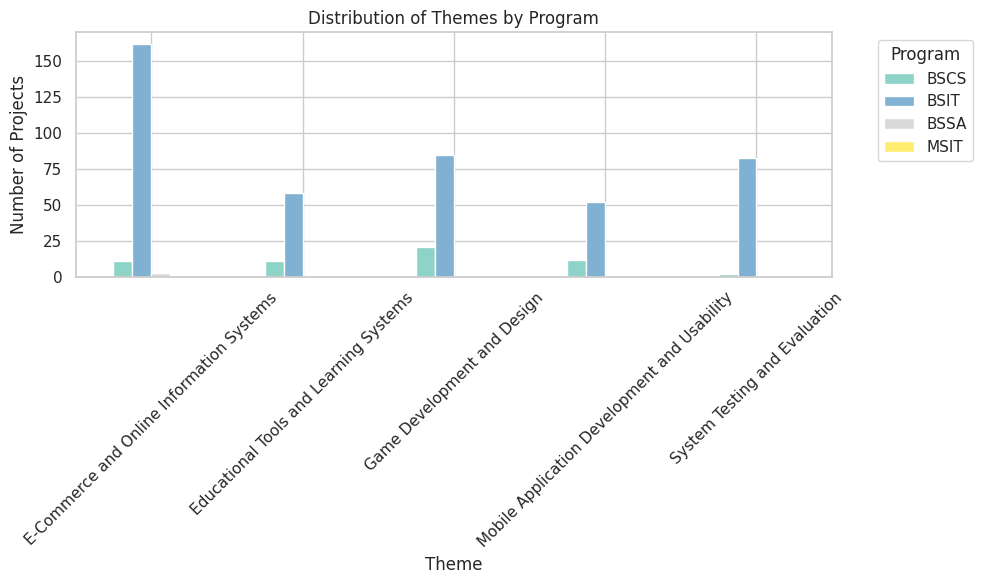

In [ ]:
# Bar plot for visual clarity
theme_program_crosstab.plot(kind='bar', figsize=(10,6), colormap='Set3')
plt.title('Distribution of Themes by Program')
plt.xlabel('Theme')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.legend(title='Program', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Cross-tab: Theme vs Year

In [ ]:
# Cross-tabulation: Themes by Year
theme_year_crosstab = pd.crosstab(df['theme'], df['Year'])

# Display
theme_year_crosstab


Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2022,2023
theme,,,,,,,,,,,,,,,,,
E-Commerce and Online Information Systems,6,2,3,1,3,11,14,23,45,12,7,3,12,4,8,16,7
Educational Tools and Learning Systems,2,2,0,2,1,1,1,10,23,3,4,3,3,3,0,3,8
Game Development and Design,0,0,0,0,1,0,6,9,26,12,2,5,14,13,10,6,2
Mobile Application Development and Usability,0,0,0,1,0,0,1,0,10,4,0,1,5,9,13,18,2
System Testing and Evaluation,0,0,0,0,1,0,0,0,2,0,0,0,0,4,8,40,30


Word Sense Disambiguation Analysis

In [ ]:
def word_sense_disambiguation(df, ambiguous_words=['system', 'application', 'development', 'design']):
    """Perform word sense disambiguation on key ambiguous terms"""

    wsd_results = []

    for word in ambiguous_words:
        # Find contexts where the ambiguous word appears
        for idx, abstract in enumerate(df['cleaned_keywords'].fillna('')):
            if word in abstract.lower():
                # Get sentence context
                tokens = word_tokenize(abstract.lower())
                if word in tokens:
                    # Apply Lesk algorithm for WSD
                    try:
                        sense = lesk(tokens, word)
                        if sense:
                            wsd_results.append({
                                'Document_Index': idx,
                                'Word': word,
                                'Context': abstract[:100] + '...',
                                'Sense': sense.name(),
                                'Definition': sense.definition(),
                                'Theme': df.iloc[idx]['theme']
                            })
                    except:
                        continue

    # Convert to DataFrame
    wsd_df = pd.DataFrame(wsd_results)

    if not wsd_df.empty:
        # Analyze sense distributions
        sense_distribution = wsd_df.groupby(['Word', 'Sense']).size().reset_index(name='Frequency')

        print("Word Sense Disambiguation Results:")
        for word in ambiguous_words:
            word_senses = wsd_df[wsd_df['Word'] == word]['Sense'].value_counts()
            if not word_senses.empty:
                print(f"\n'{word}' senses found:")
                for sense, count in word_senses.head(3).items():
                    if not wsd_df[wsd_df['Sense'] == sense].empty:
                        definition = wsd_df[wsd_df['Sense'] == sense]['Definition'].iloc[0]
                        print(f"  {sense}: {count} occurrences")
                        print(f"    Definition: {definition[:80]}...")

    return wsd_df

# Apply word sense disambiguation
wsd_results = word_sense_disambiguation(df)

Word Sense Disambiguation Results:

'system' senses found:
  system.n.03: 205 occurrences
    Definition: (physical chemistry) a sample of matter in which substances in different phases ...
  system.n.08: 107 occurrences
    Definition: the living body considered as made up of interdependent components forming a uni...
  system.n.07: 58 occurrences
    Definition: a procedure or process for obtaining an objective...

'application' senses found:
  application.n.01: 97 occurrences
    Definition: the act of bringing something to bear; using it for a particular purpose...
  application.n.04: 55 occurrences
    Definition: a program that gives a computer instructions that provide the user with tools to...

'development' senses found:
  growth.n.01: 173 occurrences
    Definition: (biology) the process of an individual organism growing organically; a purely bi...
  development.n.09: 101 occurrences
    Definition: (music) the section of a composition or movement (especially in sonata form) 

Trend Analysis Over the Years (Objective 2)



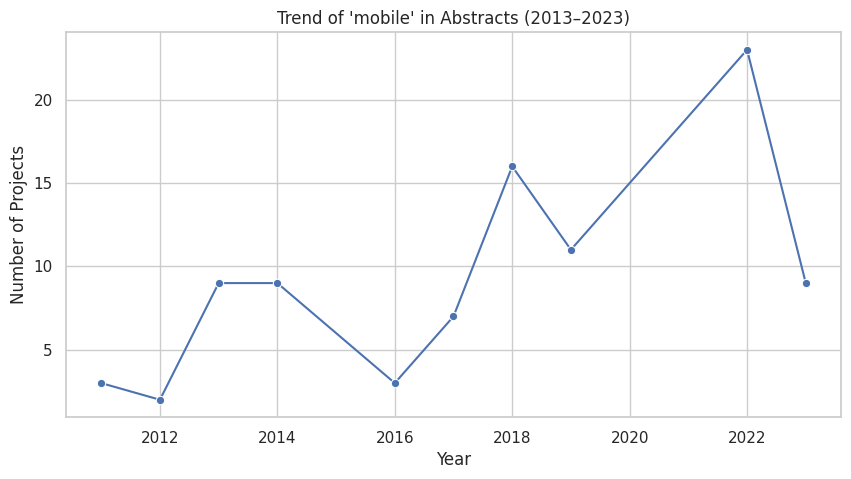

In [ ]:
# Add year column as integer
df['Year'] = df['Year'].astype(int)

# Keyword example: 'mobile' trend over time
keyword = 'mobile'

df['has_keyword'] = df['cleaned_keywords'].apply(lambda x: keyword in x)
trend_data = df[df['has_keyword']].groupby('Year').size()

# Plot keyword trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=trend_data.index, y=trend_data.values, marker='o')
plt.title(f"Trend of '{keyword}' in Abstracts (2013–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.show()


In [ ]:
# Statistical significance testing for theme trends
from scipy import stats

# Prepare data for statistical testing
theme_counts = df.groupby(['Year', 'theme']).size().unstack(fill_value=0)

# Run chi-square test to determine if there's significant association between year and theme
contingency_table = pd.crosstab(df['Year'], df['theme'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-square Test for Association Between Year and Theme:")
print(f"Chi-square value: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Interpretation: {'Significant association' if p < 0.05 else 'No significant association'} between year and theme distribution (α=0.05)")

# Linear regression for trend analysis on each theme
print("\nLinear Regression Analysis for Theme Trends:")
from scipy.stats import linregress

for theme in df['theme'].unique():
    theme_by_year = df[df['theme'] == theme].groupby('Year').size()
    if len(theme_by_year) >= 3:  # Need at least 3 data points for regression
        x = theme_by_year.index.astype(int)
        y = theme_by_year.values
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        print(f"\n{theme}:")
        print(f"Slope: {slope:.4f} (projects/year)")
        print(f"R-squared: {r_value**2:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Trend: {'Significant increasing' if slope > 0 and p_value < 0.05 else 'Significant decreasing' if slope < 0 and p_value < 0.05 else 'No significant trend'} (α=0.05)")


Chi-square Test for Association Between Year and Theme:
Chi-square value: 318.62
p-value: 0.0000
Degrees of freedom: 64
Interpretation: Significant association between year and theme distribution (α=0.05)

Linear Regression Analysis for Theme Trends:

Educational Tools and Learning Systems:
Slope: 0.1901 (projects/year)
R-squared: 0.0322
p-value: 0.5219
Trend: No significant trend (α=0.05)

Game Development and Design:
Slope: -0.1508 (projects/year)
R-squared: 0.0086
p-value: 0.7746
Trend: No significant trend (α=0.05)

E-Commerce and Online Information Systems:
Slope: 0.2997 (projects/year)
R-squared: 0.0235
p-value: 0.5573
Trend: No significant trend (α=0.05)

System Testing and Evaluation:
Slope: 2.4472 (projects/year)
R-squared: 0.6303
p-value: 0.0593
Trend: No significant trend (α=0.05)

Mobile Application Development and Usability:
Slope: 0.6302 (projects/year)
R-squared: 0.2554
p-value: 0.1362
Trend: No significant trend (α=0.05)


Compare Thesis vs. Capstone (Objective 3)

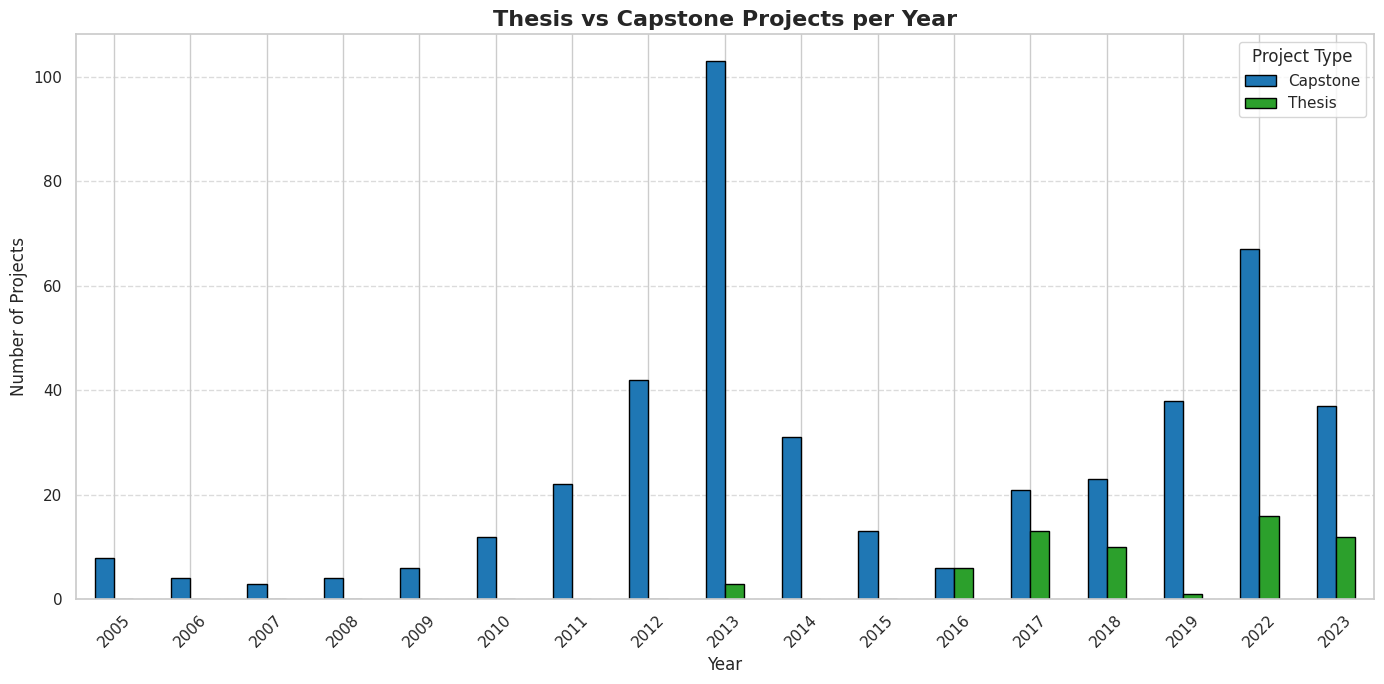

In [ ]:
import matplotlib.pyplot as plt

# Map project types based on program
df['ProjectType'] = df['Program'].apply(lambda x: 'Capstone' if 'BSIT' in x else 'Thesis')

# Group by year and project type
trend_compare = df.groupby(['Year', 'ProjectType']).size().unstack(fill_value=0)


colors = ['#1f77b4', '#2ca02c']

# Plot
trend_compare.plot(kind='bar', stacked=False, figsize=(14, 7), color=colors, edgecolor='black')
plt.title("Thesis vs Capstone Projects per Year", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Projects", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Project Type')
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

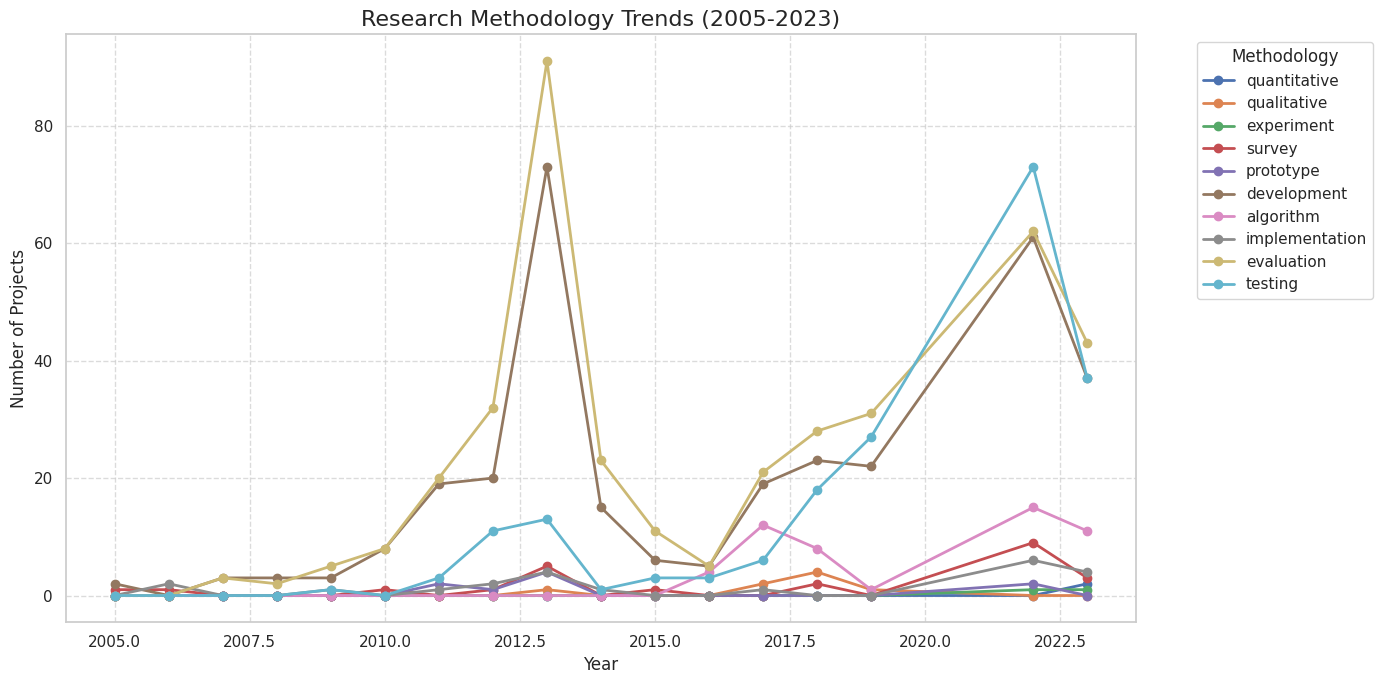

In [ ]:
# Extract methodology keywords
methodology_keywords = ['quantitative', 'qualitative', 'mixed methods', 'experiment',
                        'survey', 'case study', 'prototype', 'development', 'algorithm',
                        'implementation', 'evaluation', 'testing']

# Create columns for each methodology
for keyword in methodology_keywords:
    df[f'has_{keyword}'] = df['cleaned_keywords'].str.contains(keyword).astype(int)

# Track methodology trends over time
methodology_trends = pd.DataFrame()
for keyword in methodology_keywords:
    trend = df.groupby('Year')[f'has_{keyword}'].sum()
    methodology_trends[keyword] = trend

# Plot only methodologies that appear in the data
non_zero_methods = [col for col in methodology_trends.columns if methodology_trends[col].sum() > 0]

if non_zero_methods:
    plt.figure(figsize=(14, 7))
    methodology_trends[non_zero_methods].plot(marker='o', linewidth=2, figsize=(14, 7))
    plt.title("Research Methodology Trends (2005-2023)", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Number of Projects")
    plt.legend(title="Methodology", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No methodology keywords found in the dataset.")

<Figure size 1200x600 with 0 Axes>

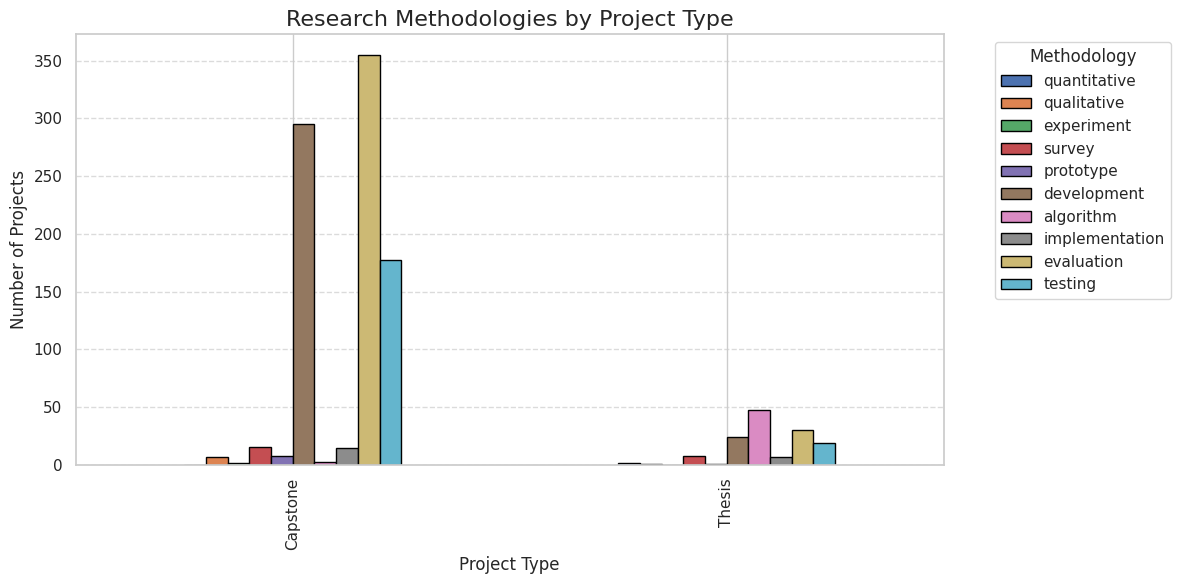

In [ ]:


# Calculate methodology distribution by project type
methodology_counts = {}
for keyword in methodology_keywords:
    # Get counts by project type for this methodology
    counts = df.groupby('ProjectType')[f'has_{keyword}'].sum()
    if counts.sum() > 0:  # Only include methodologies that appear in the data
        methodology_counts[keyword] = counts

# Convert to DataFrame if we have data
if methodology_counts:
    methodology_by_type = pd.DataFrame(methodology_counts)

    # Plot methodology distribution
    plt.figure(figsize=(12, 6))
    methodology_by_type.plot(kind='bar', figsize=(12, 6), edgecolor='black')
    plt.title("Research Methodologies by Project Type", fontsize=16)
    plt.xlabel("Project Type")
    plt.ylabel("Number of Projects")
    plt.legend(title="Methodology", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No methodology keywords found in the dataset to plot by project type.")



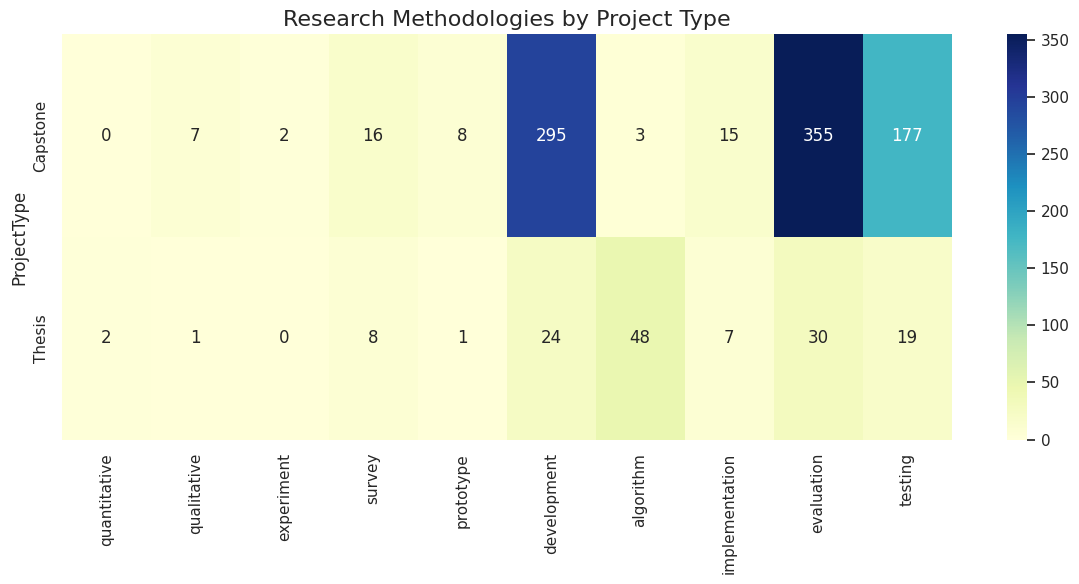

In [ ]:
# Alternative visualization: Heatmap of methodologies by project type
if methodology_counts:
    plt.figure(figsize=(12, 6))
    sns.heatmap(methodology_by_type, annot=True, cmap="YlGnBu", fmt="d")
    plt.title("Research Methodologies by Project Type", fontsize=16)
    plt.tight_layout()
    plt.show()

<Figure size 1400x700 with 0 Axes>

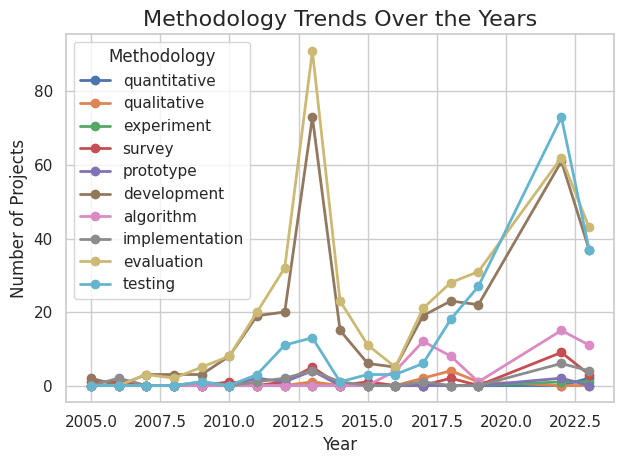

In [ ]:
if non_zero_methods:
    plt.figure(figsize=(14, 7))
    methodology_trends[non_zero_methods].plot(marker='o', linewidth=2)
    plt.title("Methodology Trends Over the Years", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Number of Projects")
    plt.legend(title='Methodology')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Analyze Alignment with Industry Trends (Objective 4)

In [ ]:
# Industry trend keywords per category
industry_trends = {
    "Software Quality and Testing": ["testing", "evaluate", "developers", "compatibility", "iso", "project"],
    "Game Development": ["game", "games", "player", "play", "adventure", "android"],
    "E-Commerce and Web Systems": ["website", "online", "customers", "products", "users", "information"],
    "Educational Technology": ["learning", "students", "school", "teachers", "subject", "animation", "grade"],
    "Mobile Application Development": ["android", "mobile", "application", "usability", "functionality", "user"]
}

# Topics extracted from the dataset (replace with actual NLP output if dynamic)
topics = {
    "Topic 1": ["project", "testing", "developers", "developed", "25010", "compatibility", "experts", "respondents", "iso", "evaluate"],
    "Topic 2": ["game", "player", "acceptable", "games", "players", "android", "algorithm", "adventure", "play", "different"],
    "Topic 3": ["information", "website", "online", "san", "customers", "city", "pablo", "users", "products", "laguna"],
    "Topic 4": ["learning", "students", "school", "button", "grade", "teachers", "animation", "subject", "student", "computer"],
    "Topic 5": ["application", "android", "mobile", "algorithm", "user", "evaluation", "using", "functionality", "users", "usability"]
}

# Function to compute keyword matches and alignment
def analyze_alignment(topics, trends):
    results = []
    for topic_name, keywords in topics.items():
        trend_matches = {}
        for trend, trend_keywords in trends.items():
            match_count = len(set(keywords).intersection(trend_keywords))
            trend_matches[trend] = match_count
        best_match = max(trend_matches, key=trend_matches.get)
        alignment_score = trend_matches[best_match]
        results.append({
            "Topic": topic_name,
            "Best_Matching_Trend": best_match,
            "Score": alignment_score,
            "Matched_Keywords": set(keywords).intersection(industry_trends[best_match])
        })
    return results

# Analyze and display results
alignment_results = analyze_alignment(topics, industry_trends)

import pandas as pd

df = pd.DataFrame(alignment_results)
df = df.sort_values(by="Score", ascending=False)
print(df)

# Optional: Display as markdown for copy-pasting into reports
for _, row in df.iterrows():
    print(f"### {row['Topic']}")
    print(f"- **Best Matching Trend:** {row['Best_Matching_Trend']}")
    print(f"- **Matched Keywords:** {', '.join(row['Matched_Keywords'])}")
    print(f"- **Alignment Score:** {row['Score']}")
    print()


     Topic             Best_Matching_Trend  Score  \
3  Topic 4          Educational Technology      7   
0  Topic 1    Software Quality and Testing      6   
1  Topic 2                Game Development      6   
2  Topic 3      E-Commerce and Web Systems      6   
4  Topic 5  Mobile Application Development      6   

                                    Matched_Keywords  
3  {subject, teachers, learning, grade, students,...  
0  {testing, project, evaluate, developers, iso, ...  
1    {adventure, play, games, android, player, game}  
2  {website, online, products, users, information...  
4  {functionality, mobile, application, android, ...  
### Topic 4
- **Best Matching Trend:** Educational Technology
- **Matched Keywords:** subject, teachers, learning, grade, students, animation, school
- **Alignment Score:** 7

### Topic 1
- **Best Matching Trend:** Software Quality and Testing
- **Matched Keywords:** testing, project, evaluate, developers, iso, compatibility
- **Alignment Score:** 6

Correlation Analysis Between Theme and Years

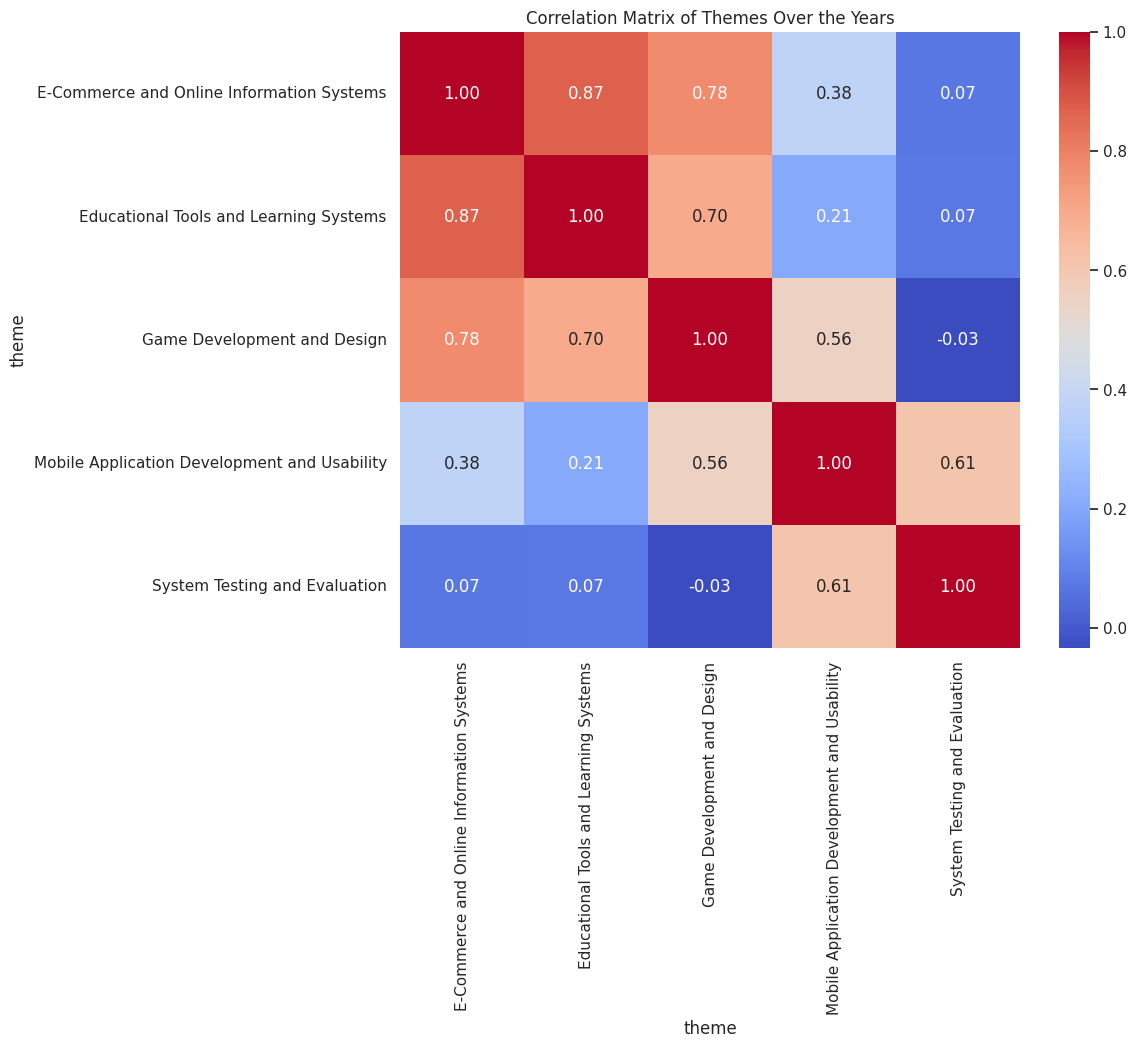

In [ ]:
# Create a pivot table for correlation analysis
# Using the previously created theme_year_crosstab which has the correct data
theme_year_matrix = theme_year_crosstab

# Display the correlation matrix
# Transpose the matrix to calculate correlations between themes across years
correlation_matrix = theme_year_matrix.T.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Themes Over the Years")
plt.show()

In [ ]:
# Calculate correlation between themes over time
theme_correlations = theme_year_matrix.corr()
print("Theme Correlations (Pearson):")
print(theme_correlations.round(3))

Theme Correlations (Pearson):
Year   2005   2006   2007   2008   2009   2010   2011   2012   2013   2014  \
Year                                                                         
2005  1.000  0.840  0.943  0.413  0.910  0.969  0.832  0.921  0.851  0.495   
2006  0.840  1.000  0.612  0.764  0.667  0.681  0.483  0.782  0.709  0.216   
2007  0.943  0.612  1.000  0.134  0.919  0.996  0.916  0.864  0.807  0.590   
2008  0.413  0.764  0.134  1.000  0.055  0.210 -0.031  0.297  0.294 -0.152   
2009  0.910  0.667  0.919  0.055  1.000  0.927  0.881  0.908  0.814  0.573   
2010  0.969  0.681  0.996  0.210  0.927  1.000  0.904  0.889  0.828  0.571   
2011  0.832  0.483  0.916 -0.031  0.881  0.904  1.000  0.909  0.913  0.859   
2012  0.921  0.782  0.864  0.297  0.908  0.889  0.909  1.000  0.977  0.739   
2013  0.851  0.709  0.807  0.294  0.814  0.828  0.913  0.977  1.000  0.838   
2014  0.495  0.216  0.590 -0.152  0.573  0.571  0.859  0.739  0.838  1.000   
2015  0.944  0.892  0.829  0.463  

In [ ]:
import numpy as np

# Revert to the original df before reassignment in cell klgmfKcXrd1a
df = pd.read_csv('trend_analysis dataset.csv')
df.dropna(subset=['Title', 'Abstract Keywords'], inplace=True)
df['cleaned_keywords'] = df['Abstract Keywords'].apply(clean_text)
df['Year'] = df['Year'].astype(int) # Ensure 'Year' is integer type

yearly_counts = df.groupby('Year').size()
growth_rates = yearly_counts.pct_change() * 100

print("Year-over-Year Growth Rates:")
for year, rate in growth_rates.items():
    if not np.isnan(rate):
        print(f"{year}: {rate:.1f}%")

Year-over-Year Growth Rates:
2006: -50.0%
2007: -25.0%
2008: 33.3%
2009: 50.0%
2010: 100.0%
2011: 83.3%
2012: 90.9%
2013: 152.4%
2014: -70.8%
2015: -58.1%
2016: -7.7%
2017: 183.3%
2018: -2.9%
2019: 18.2%
2022: 112.8%
2023: -41.0%


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '2005'),
  Text(1, 0, '2006'),
  Text(2, 0, '2007'),
  Text(3, 0, '2008'),
  Text(4, 0, '2009'),
  Text(5, 0, '2010'),
  Text(6, 0, '2011'),
  Text(7, 0, '2012'),
  Text(8, 0, '2013'),
  Text(9, 0, '2014'),
  Text(10, 0, '2015'),
  Text(11, 0, '2016'),
  Text(12, 0, '2017'),
  Text(13, 0, '2018'),
  Text(14, 0, '2019'),
  Text(15, 0, '2022'),
  Text(16, 0, '2023')])

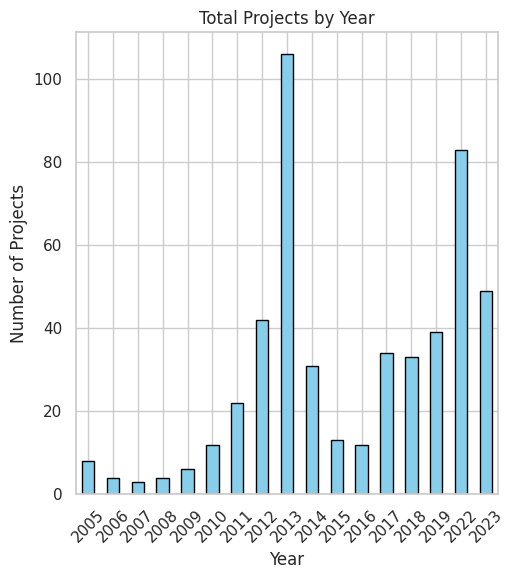

In [ ]:
# Plot growth rates
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Projects by Year')
plt.xlabel('Year')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)


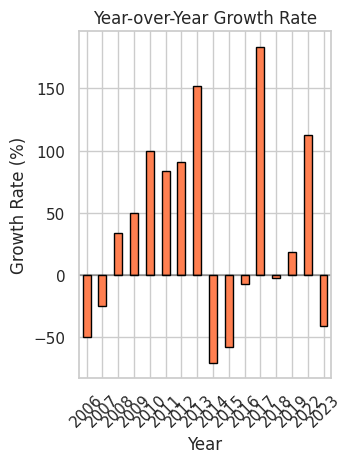

In [ ]:
plt.subplot(1, 2, 2)
growth_rates[1:].plot(kind='bar', color='coral', edgecolor='black')
plt.title('Year-over-Year Growth Rate')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Program distribution
program_dist = df['Program'].value_counts()
print("Program Distribution:")
print(program_dist)

Program Distribution:
Program
BSIT    440
BSCS     57
BSSA      3
MSIT      1
Name: count, dtype: int64


In [ ]:
# Program trend over years
program_year_trend = df.groupby(['Year', 'Program']).size().unstack(fill_value=0)
print("\nProgram Distribution by Year:")
print(program_year_trend)


Program Distribution by Year:
Program  BSCS  BSIT  BSSA  MSIT
Year                           
2005        0     8     0     0
2006        0     4     0     0
2007        0     3     0     0
2008        0     4     0     0
2009        0     6     0     0
2010        0    12     0     0
2011        0    22     0     0
2012        0    42     0     0
2013        0   103     3     0
2014        0    31     0     0
2015        0    13     0     0
2016        6     6     0     0
2017       13    21     0     0
2018       10    23     0     0
2019        1    38     0     0
2022       15    67     0     1
2023       12    37     0     0


In [ ]:
# Chi-square test for program-year association
from scipy.stats import chi2_contingency

if len(program_dist) > 1:
    contingency_program_year = pd.crosstab(df['Year'], df['Program'])
    chi2_prog, p_prog, dof_prog, expected_prog = chi2_contingency(contingency_program_year)
    print(f"\nChi-square test (Program vs Year):")
    print(f"Chi-square: {chi2_prog:.3f}, p-value: {p_prog:.4f}")
    print(f"Result: {'Significant' if p_prog < 0.05 else 'Not significant'} association")


Chi-square test (Program vs Year):
Chi-square: 116.843, p-value: 0.0000
Result: Significant association


In [ ]:
# Calculate theme dominance by year
yearly_theme_dominance = []

# Use the theme_year_crosstab which has theme counts by year
for year in theme_year_crosstab.columns:
    # Get the theme with the maximum count for the current year
    top_theme = theme_year_crosstab[year].idxmax()
    dominance_count = theme_year_crosstab[year].max()
    total_projects_in_year = theme_year_crosstab[year].sum()

    # Avoid division by zero if there are no projects in a year
    dominance_pct = (dominance_count / total_projects_in_year) * 100 if total_projects_in_year > 0 else 0

    yearly_theme_dominance.append({
        'Year': year,
        'Dominant_Theme': top_theme,
        'Dominance_Percentage': dominance_pct
    })

# Convert to DataFrame and display
yearly_theme_dominance_df = pd.DataFrame(yearly_theme_dominance)
print("\nDominant Theme by Year:")
print(yearly_theme_dominance_df)


Dominant Theme by Year:
    Year                                Dominant_Theme  Dominance_Percentage
0   2005     E-Commerce and Online Information Systems             75.000000
1   2006     E-Commerce and Online Information Systems             50.000000
2   2007     E-Commerce and Online Information Systems            100.000000
3   2008        Educational Tools and Learning Systems             50.000000
4   2009     E-Commerce and Online Information Systems             50.000000
5   2010     E-Commerce and Online Information Systems             91.666667
6   2011     E-Commerce and Online Information Systems             63.636364
7   2012     E-Commerce and Online Information Systems             54.761905
8   2013     E-Commerce and Online Information Systems             42.452830
9   2014     E-Commerce and Online Information Systems             38.709677
10  2015     E-Commerce and Online Information Systems             53.846154
11  2016                   Game Development and Des

In [ ]:
dominance_df = pd.DataFrame(yearly_theme_dominance)
print("Yearly Theme Dominance:")
print(dominance_df.to_string(index=False))


Yearly Theme Dominance:
 Year                               Dominant_Theme  Dominance_Percentage
 2005    E-Commerce and Online Information Systems             75.000000
 2006    E-Commerce and Online Information Systems             50.000000
 2007    E-Commerce and Online Information Systems            100.000000
 2008       Educational Tools and Learning Systems             50.000000
 2009    E-Commerce and Online Information Systems             50.000000
 2010    E-Commerce and Online Information Systems             91.666667
 2011    E-Commerce and Online Information Systems             63.636364
 2012    E-Commerce and Online Information Systems             54.761905
 2013    E-Commerce and Online Information Systems             42.452830
 2014    E-Commerce and Online Information Systems             38.709677
 2015    E-Commerce and Online Information Systems             53.846154
 2016                  Game Development and Design             41.666667
 2017                  Game

Diversity Index Calculation

In [ ]:
def calculate_shannon_diversity(series):
    """Calculate Shannon Diversity Index"""
    proportions = series.value_counts(normalize=True)
    return -sum(proportions * np.log(proportions))


In [ ]:
# Calculate diversity for each year
yearly_diversity = []

# Re-apply necessary preprocessing and topic assignment to get the 'theme' column back
df = pd.read_csv('trend_analysis dataset.csv')
df.dropna(subset=['Title', 'Abstract Keywords'], inplace=True)
df['cleaned_keywords'] = df['Abstract Keywords'].apply(clean_text)
df['Year'] = df['Year'].astype(int)

# Re-create the vectorizer and NMF model with the same parameters as before
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_keywords'])
nmf_model = NMF(n_components=5, random_state=42)
W = nmf_model.fit_transform(X)

# Define topic names based on top keywords (copying from a previous cell for consistency)
topic_names = {
    0: "System Testing and Evaluation",
    1: "Game Development and Design",
    2: "E-Commerce and Online Information Systems",
    3: "Educational Tools and Learning Systems",
    4: "Mobile Application Development and Usability"
}

# Assign topics to each document
df['topic'] = W.argmax(axis=1)
df['theme'] = df['topic'].map(topic_names)

# Now calculate diversity for each year
for year in sorted(df['Year'].unique()):
    year_themes = df[df['Year'] == year]['theme']
    # Only calculate diversity if there are themes for the year
    if not year_themes.empty:
        diversity = calculate_shannon_diversity(year_themes)
        yearly_diversity.append({'Year': year, 'Diversity_Index': diversity})

# Convert to DataFrame and display
yearly_diversity_df = pd.DataFrame(yearly_diversity)
print("\nYearly Theme Diversity:")
print(yearly_diversity_df)


Yearly Theme Diversity:
    Year  Diversity_Index
0   2005         0.562335
1   2006         0.693147
2   2007        -0.000000
3   2008         1.039721
4   2009         1.242453
5   2010         0.286836
6   2011         0.922981
7   2012         1.001545
8   2013         1.337601
9   2014         1.224994
10  2015         0.983961
11  2016         1.265001
12  2017         1.229046
13  2018         1.450885
14  2019         1.365068
15  2022         1.310531
16  2023         1.135383


In [ ]:
diversity_df = pd.DataFrame(yearly_diversity)
print("Theme Diversity by Year (Shannon Index):")
print(diversity_df.to_string(index=False))

Theme Diversity by Year (Shannon Index):
 Year  Diversity_Index
 2005         0.562335
 2006         0.693147
 2007        -0.000000
 2008         1.039721
 2009         1.242453
 2010         0.286836
 2011         0.922981
 2012         1.001545
 2013         1.337601
 2014         1.224994
 2015         0.983961
 2016         1.265001
 2017         1.229046
 2018         1.450885
 2019         1.365068
 2022         1.310531
 2023         1.135383


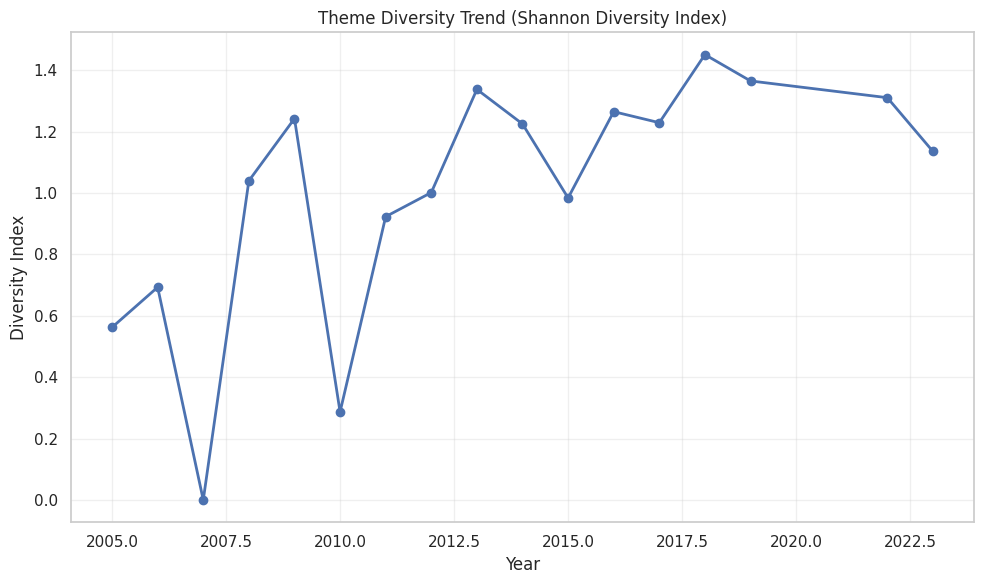

In [ ]:
# Plot diversity trend
plt.figure(figsize=(10, 6))
plt.plot(diversity_df['Year'], diversity_df['Diversity_Index'],
         marker='o', linewidth=2, markersize=6)
plt.title('Theme Diversity Trend (Shannon Diversity Index)')
plt.xlabel('Year')
plt.ylabel('Diversity Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Keyword Evolution Analysis

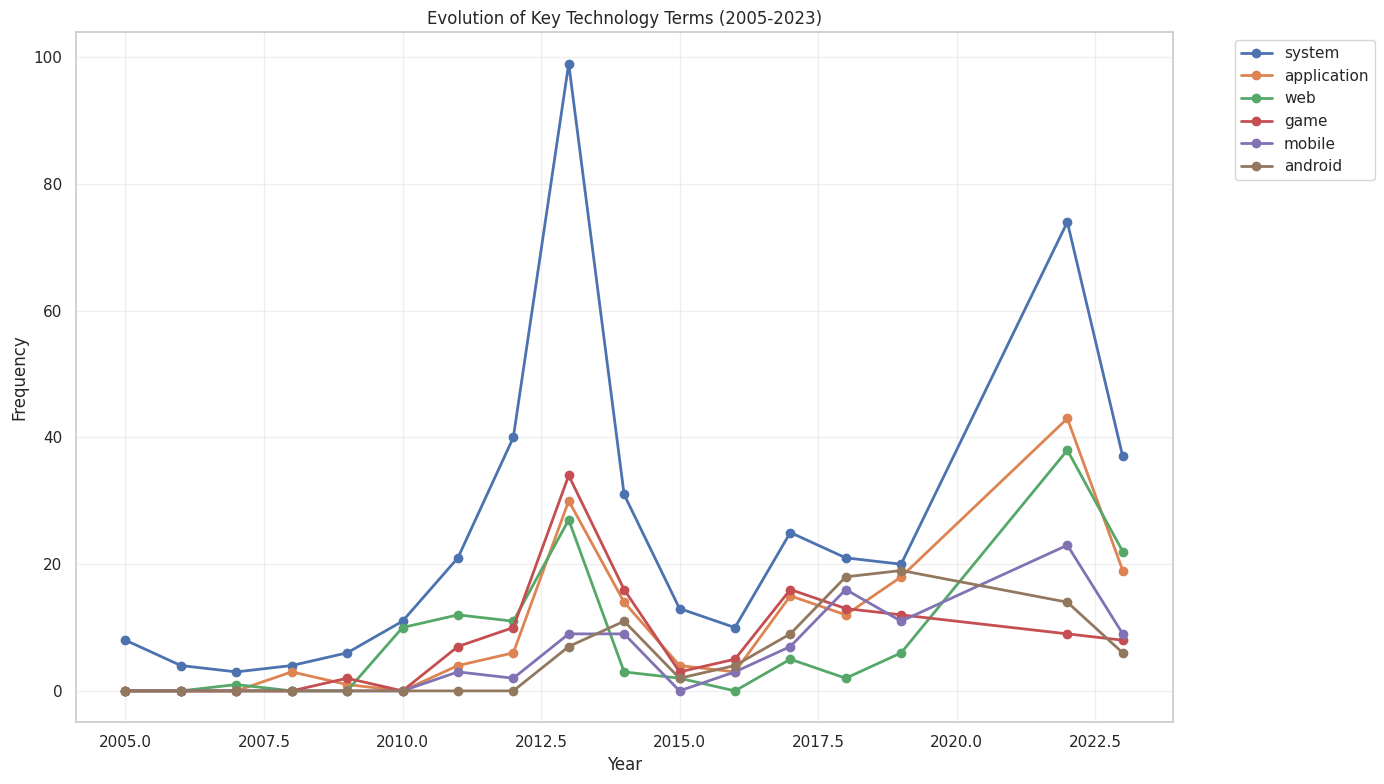

In [ ]:
# Track specific technology keywords over time
tech_keywords = ['android', 'mobile', 'web', 'game', 'algorithm',
                'database', 'system', 'application', 'online', 'learning']

keyword_trends = {}
for keyword in tech_keywords:
    yearly_counts = []
    for year in sorted(df['Year'].unique()):
        year_data = df[df['Year'] == year]
        count = sum(year_data['cleaned_keywords'].str.contains(keyword, case=False))
        yearly_counts.append(count)
    keyword_trends[keyword] = yearly_counts

# Create DataFrame for plotting
keyword_trends_df = pd.DataFrame(keyword_trends, index=sorted(df['Year'].unique()))

# Plot top trending keywords
top_keywords = keyword_trends_df.sum().nlargest(6).index
plt.figure(figsize=(14, 8))
for keyword in top_keywords:
    plt.plot(keyword_trends_df.index, keyword_trends_df[keyword],
             marker='o', linewidth=2, label=keyword)

plt.title('Evolution of Key Technology Terms (2005-2023)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Emerging vs Declining **Themes**

In [ ]:
# Calculate trend slopes for each theme
theme_slopes = {}
for theme in df['theme'].unique():
    theme_yearly = []
    years = sorted(df['Year'].unique())
    for year in years:
        count = len(df[(df['Year'] == year) & (df['theme'] == theme)])
        theme_yearly.append(count)

    if len(theme_yearly) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, theme_yearly)
        theme_slopes[theme] = {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value,
            'trend': 'Emerging' if slope > 0.1 else 'Declining' if slope < -0.1 else 'Stable'
        }

print("Theme Trend Classification:")
for theme, stats_dict in theme_slopes.items():
    print(f"\n{theme}:")
    print(f"  Slope: {stats_dict['slope']:.3f}")
    print(f"  R²: {stats_dict['r_squared']:.3f}")
    print(f"  Classification: {stats_dict['trend']}")
    significance = "Significant" if stats_dict['p_value'] < 0.05 else "Not significant"
    print(f"  Statistical Significance: {significance} (p={stats_dict['p_value']:.4f})")

Theme Trend Classification:

Educational Tools and Learning Systems:
  Slope: 0.166
  R²: 0.027
  Classification: Emerging
  Statistical Significance: Not significant (p=0.5308)

Game Development and Design:
  Slope: 0.497
  R²: 0.145
  Classification: Emerging
  Statistical Significance: Not significant (p=0.1321)

E-Commerce and Online Information Systems:
  Slope: 0.300
  R²: 0.023
  Classification: Emerging
  Statistical Significance: Not significant (p=0.5573)

System Testing and Evaluation:
  Slope: 1.482
  R²: 0.483
  Classification: Emerging
  Statistical Significance: Significant (p=0.0020)

Mobile Application Development and Usability:
  Slope: 0.652
  R²: 0.420
  Classification: Emerging
  Statistical Significance: Significant (p=0.0049)


# Summary Statistics

In [ ]:
# Display basic summary of the dataset
print(f"Dataset Overview:")
print(f"- Total Projects: {len(df)}")  # Total number of research projects
print(f"- Years Covered: {df['Year'].min()} - {df['Year'].max()}")  # Range of years included
print(f"- Number of Programs: {df['Program'].nunique()}")  # Unique degree programs in the dataset
print(f"- Number of Themes: {df['theme'].nunique()}")  # Number of distinct research themes
print(f"- Average Projects per Year: {len(df) / df['Year'].nunique():.1f}")  # Mean number of projects per year

# Display how projects are distributed across different themes
print(f"\nTheme Distribution:")
theme_stats = df['theme'].value_counts()
for theme, count in theme_stats.items():
    percentage = (count / len(df)) * 100
    print(f"- {theme}: {count} ({percentage:.1f}%)")

# Display number of projects per year and their percentage
print(f"\nYear Distribution:")
year_stats = df['Year'].value_counts().sort_index()
for year, count in year_stats.items():
    percentage = (count / len(df)) * 100
    print(f"- {year}: {count} ({percentage:.1f}%)")


Dataset Overview:
- Total Projects: 501
- Years Covered: 2005 - 2023
- Number of Programs: 4
- Number of Themes: 5
- Average Projects per Year: 29.5

Theme Distribution:
- E-Commerce and Online Information Systems: 177 (35.3%)
- Game Development and Design: 106 (21.2%)
- System Testing and Evaluation: 85 (17.0%)
- Educational Tools and Learning Systems: 69 (13.8%)
- Mobile Application Development and Usability: 64 (12.8%)

Year Distribution:
- 2005: 8 (1.6%)
- 2006: 4 (0.8%)
- 2007: 3 (0.6%)
- 2008: 4 (0.8%)
- 2009: 6 (1.2%)
- 2010: 12 (2.4%)
- 2011: 22 (4.4%)
- 2012: 42 (8.4%)
- 2013: 106 (21.2%)
- 2014: 31 (6.2%)
- 2015: 13 (2.6%)
- 2016: 12 (2.4%)
- 2017: 34 (6.8%)
- 2018: 33 (6.6%)
- 2019: 39 (7.8%)
- 2022: 83 (16.6%)
- 2023: 49 (9.8%)


# Recommendations

In [ ]:
# Most growing theme
growing_themes = [theme for theme, stats_dict in theme_slopes.items()
                 if stats_dict['trend'] == 'Emerging']
declining_themes = [theme for theme, stats_dict in theme_slopes.items()
                   if stats_dict['trend'] == 'Declining']

print("CURRICULUM RECOMMENDATIONS:")
if growing_themes:
    print(f"✓ Strengthen focus on: {', '.join(growing_themes)}")
if declining_themes:
    print(f"⚠ Review relevance of: {', '.join(declining_themes)}")

# Peak diversity year
peak_diversity_year = diversity_df.loc[diversity_df['Diversity_Index'].idxmax(), 'Year']
print(f"✓ Year {peak_diversity_year} showed highest theme diversity - analyze factors that contributed")

# Most frequent keywords for industry alignment
top_industry_terms = keyword_trends_df.sum().nlargest(3)
print(f"✓ Current industry alignment strongest in: {', '.join(top_industry_terms.index)}")

CURRICULUM RECOMMENDATIONS:
✓ Strengthen focus on: Educational Tools and Learning Systems, Game Development and Design, E-Commerce and Online Information Systems, System Testing and Evaluation, Mobile Application Development and Usability
✓ Year 2018 showed highest theme diversity - analyze factors that contributed
✓ Current industry alignment strongest in: system, application, web


In [ ]:
# Add this to create a final summary table
summary_results = pd.DataFrame({
    'Metric': ['Total Projects', 'Most Dominant Theme', 'Peak Diversity Year',
               'Strongest Growing Theme', 'Industry Alignment Score'],
    'Value': [len(df),
              df['theme'].mode()[0],
              diversity_df.loc[diversity_df['Diversity_Index'].idxmax(), 'Year'],
              max(theme_slopes.items(), key=lambda x: x[1]['slope'])[0],
              f"{np.mean([result['Score'] for result in alignment_results]):.1f}/10"]
})
print("EXECUTIVE SUMMARY:")
print(summary_results.to_string(index=False))

EXECUTIVE SUMMARY:
                  Metric                                     Value
          Total Projects                                       501
     Most Dominant Theme E-Commerce and Online Information Systems
     Peak Diversity Year                                      2018
 Strongest Growing Theme             System Testing and Evaluation
Industry Alignment Score                                    6.2/10


In [ ]:
# Add specific numbers to recommendations
print("\nQUANTIFIED CURRICULUM RECOMMENDATIONS:")
for theme, stats in theme_slopes.items():
    if stats['trend'] == 'Emerging' and stats['p_value'] < 0.05:
        projected_growth = abs(stats['slope'] * 5)
        print(f"📈 EXPAND: {theme} - Increase by {projected_growth:.0f} projects over 5 years")
    elif stats['trend'] == 'Declining' and stats['p_value'] < 0.05:
        decline_rate = abs(stats['slope'] * 100)
        print(f"⚠️ REVIEW: {theme} - Declining at {decline_rate:.1f}% per year")


QUANTIFIED CURRICULUM RECOMMENDATIONS:
📈 EXPAND: System Testing and Evaluation - Increase by 7 projects over 5 years
📈 EXPAND: Mobile Application Development and Usability - Increase by 3 projects over 5 years
